# Project1: Particle identification in Liquid Argon Time Projection Chambers

<img src="http://deeplearnphysics.org/DataChallenge/static/images/Entry078_data.png" alt="TPC3D" style="width: 400px;"/>

## Introduction

---

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Data Scientist (n.): Person who is better at statistics than any software engineer and better at software engineering than any statistician.</p>&mdash; Josh Wills (@josh_wills) <a href="https://twitter.com/josh_wills/status/198093512149958656?ref_src=twsrc%5Etfw">May 3, 2012</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

---
### Time Projection Chambers (TPC)
Liquid argon TPCs are a type of neutrino detector which aims at providing high-resolution 3D track reconstruction which can in principle provide unprecedented detail in neutrino event reconstruction.

Charged particles in liquid argon produce ionization electrons, which drift to the readout wire planes in an electric field of 273 V/cm. It takes 2.3 ms for an ionization electron to drift across the full width of the detector.
One such LArTPC detector is found in the MicroBooNE experiment. MicroBoone has been recording data since 2015, and continuously records charge drifted and its arrival time on each wire. 
As a charged particle passes through a medium, it will create ionisation. In a TPC, an electric field causes the produced electrons to drift to anode wires at the end of the vessel. The drift time and the position of the hit wire are combined to provide a 3D reconstruction of the event.

Wire and time data can be converted into an image format (charge on each wire versus drift time) while maintaining high resolution in wire, time and charge amplitude space. These information-rich
LArTPC images are suitable for applying deep learning tools.


### Example of first images from MicroBooNE experiment
Liquid argon TPCs are ideal for neutrino experiments because they provide a relatively large target mass (unlike gas TPCs, which by their nature have relatively low densities). Neutrino interactions with LAr nuclei can result in several distinc signatures, such as a proton (p) and electron (e) being produced at a vertex point ([images from 2010.08653 [hep-ex]](https://inspirehep.net/literature/1823841)):

<img src="https://inspirehep.net/files/cba430719ebf8bcb922cda5f98cb9824" alt="MicroBooNE" style="width: 300px;"/> 

a proton, electron and photon (y) being produced from a vertex point. The photon flies through the material undetected and converts to a electron and positron pair ([pair production](https://en.wikipedia.org/wiki/Pair_production)) creating an electromagnetic shower.

<img src="https://inspirehep.net/files/619950f112f0d77089e97134025c6d4e" alt="MicroBooNE" style="width: 300px;"/> 

a proton and muon:

<img src="https://inspirehep.net/files/9fe207573f051203a98987930e7a56c1" alt="MicroBooNE" style="width: 300px;"/> 

and many other topologies. Classification of particles within the detector volume is therefore vital to being able to detect and measure neutrino collisions. You can read up on how MicroBooNE designed a convolutional neural network to identify images at [2010.08653 [hep-ex]](https://inspirehep.net/literature/1823841), which may serve as inpiration for your own CNNs.

## TPC DATASET
We will be using the open dataset from [deeplearningphysics.org](http://deeplearnphysics.org/DataChallenge/), which consists of liquid argon time projection chamber (LArTPC) simulated data. There are some great resources in terms of [Tutorials](http://deeplearnphysics.org/Blog/tutorial_summary.html#tutorial_summary) which describe the data, though the code that is used there is not applicable here directly.

The subset of the dataset used are 90K in total simulated events for the purpouse of particle classification. Unlike the images we see above, the events here only have one particle in them, for the purpouse of doing particle by particle classification.

Each event contains 3 projected images on the XY, YZ, and ZX planes.
Each 2D image spans 128cm x 128cm space with 256 x 256 pixels, meaning each pixel corresponds to 0.5 cm in vertical and horizontal size. 

### Example 
Three 2D projected images from an event of a simulated electron. Blue colors are lower pixel intensity, meaning little to no ionisation capture, while red pixels are hot, meaning high ionisation. The point where the true particle is produced is marked with an X is taken from the truth information.

![panes](https://cernbox.cern.ch/index.php/s/ulFmgU3nAjw9X8i/download)

In [1]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential, load_model, save_model
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D,RepeatVector, Conv2DTranspose, MaxPooling2D, Concatenate, Lambda,BatchNormalization, UpSampling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, ParameterGrid
from sklearn.metrics import confusion_matrix
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last
import scipy.sparse as sparse



---
### The image dataset

You can download the datasets from [this folder](https://cernbox.cern.ch/index.php/s/qk8uZgYlg7VubRi). You need both `LArTPC_images_90k.npz` and `LArTPC_truth_90k.npy`

In [3]:
images = sparse.load_npz("LArTPC_images_90k.npz")
print(type(images),images.shape,np.prod(images.shape))

<class 'scipy.sparse.csr.csr_matrix'> (90000, 196608) 514850816


**Note on image data**

The data has been pre-prepared and loaded as **sparse matrices**. We use this special format since each image has `(256x256x3)= ` 197 thousand pixels. Loading the entire 90'000 images in a **dense matrix** (every value filled) to RAM would be **17 billion pixels and over 30GB** of nessesary RAM!

However, since we have lots and lots of 0s in the images, which are largely empty except for pixels with particle activity, we can ignore the 0s with a sparce representation of the data, by keeping track of the index of the active pixels.


In [4]:
images

<90000x196608 sparse matrix of type '<class 'numpy.float64'>'
	with 66286812 stored elements in Compressed Sparse Row format>

In [5]:
max_colour = images.max(axis=None)

With our sparse representation we only load **66 million active pixels** and their indexes (positions), which only take up around **500 MB**! 

Notice that our data images are flattened to 196608 pixels from the original (256,256,3). This is because sparce matrices only support two dimensional matrices. To get back our original image we need to reshape the image back.

Here is a function to retrive the original 3 images in the XY, YZ and ZX planes

**IMPORTANT:** Converting the images this way requires conversion to dense matrix, meaning the zeros are reintreduced. Hece we should only do this on a few events! 

In [166]:
def toimage(sparsearray):
    #Convert to dense array, and reshape to three 2D images
    reshape = sparsearray.toarray().reshape((256,256,3))
    return reshape[:,:,0], reshape[:,:,1], reshape[:,:,2]

Lets grab the 1st particle and retrieve the images using the `jet` color map.



In [167]:
XY,YZ,ZX = toimage(images[0])

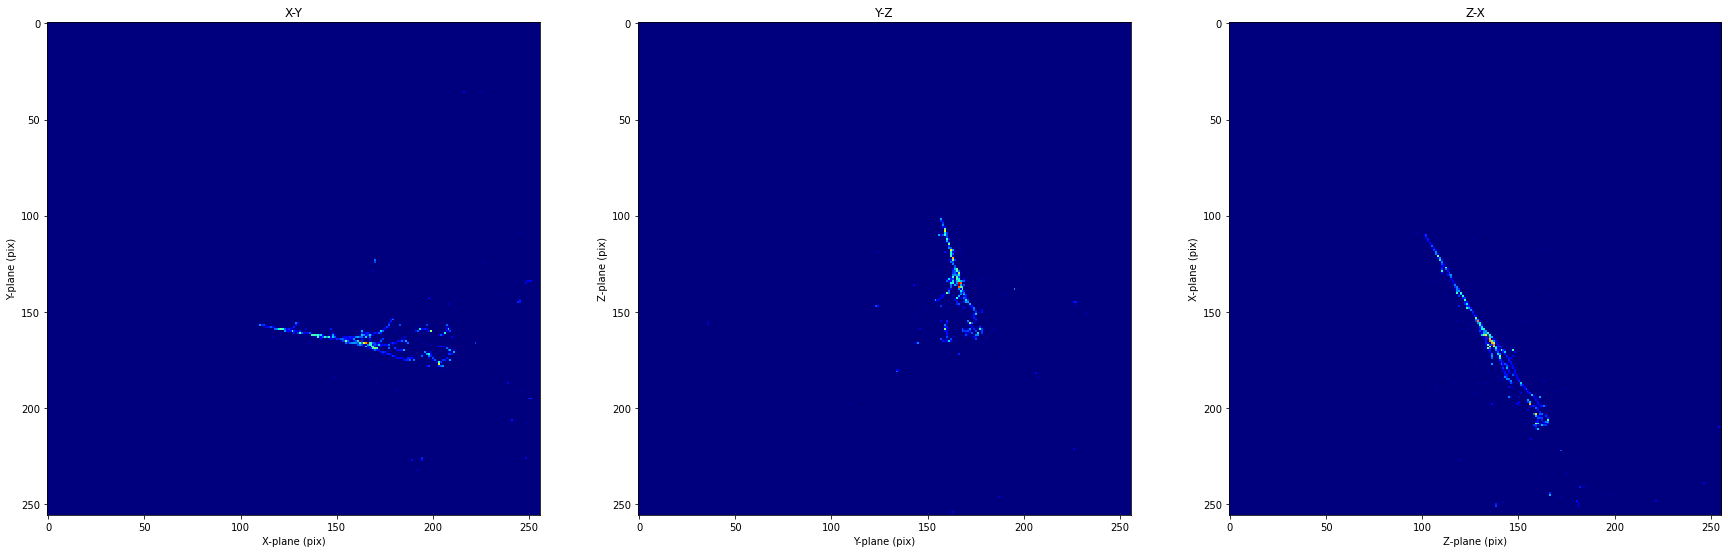

In [168]:
labels=["X-Y","Y-Z","Z-X"]
ilist= toimage(images[0])
fig = plt.figure(figsize=(30,10))
for index, image in enumerate(ilist):

    plt.subplot(1,3,index+1)
    #Show the image with imshow:
    plt.imshow(image, interpolation='none',cmap='jet')
    plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
    plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
    plt.title(labels[index])
#fig.savefig("lar_planes.png")

---
### Truth information

Real data in a neutrino experiment does not come with labels, but since our dataset is simulated, we have the **truth level information** of the particles. We load the truth dataset here.

In [9]:
truth = np.load("LArTPC_truth_90k.npy")

We have eight truth arrays present in the dataset

- The particle ID (particle type ID as defined by the [particle data group](https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf))
    - 11   : 'electron',
    - 22   : 'photon',
    - 13   : 'muon',
    - 211  : 'pion',
    - 2212 : 'proton'
- The total momentum (p) of the initial particle in MeV
- The x component (px) of momentum in MEV
- The y component (py) of momentum in MEV
- The x component (pz) of momentum in MEV
- The x position of the production of the particle in cm
- The y position of the production of the particle in cm
- The z position of the production of the particle in cm


In [10]:
p_id , p_ptot, p_px, p_py, p_pz, p_x, p_y, p_z= (truth[:,i] for i in range(truth.shape[1]))

In [11]:
truth.shape

(90000, 8)

# Project

For the project are required to perform an in depth investigation of the image dataset, and design **two** machine learning techniques from the dataset. The first tasks are **compulsary** where you are required explore the data and create an algorithm to identify/classify the particle in each event.  

## Task 0: Data exploration
* Explore a few images from each particle type, trying to identify how the particles are different between categories. Explore how the images change with different initial momenta. Remember that each event has three 2D images which should be veiwed simultaneously to get the full picture.
* Explore the truth information to get an idea of the dataset composition.

## Task 1: Image classification
* Create an algorithm to identify each event as being from one of five types of particles present in the datase
* You are strongly encouraged to use a convolutional neural network (CNN) classifier on the images, though this is not compulsary.
* Explore different architectures for the model, and explain in detail your choice of model, and the final parameters chosen. Consider doing a robust hyperparameter search.
* Explore the results and documents your findings. Ask as many questions about your model as you can, and document your findings.
    * Which particles are easy to identify, and which are not? 
    * What are the physics reasons for why some particles are similar?
    * Is there a dependence on particle position or momentum in your classifier for certain particle types?
    * Can you come up with a selection which gives good paricle purity?

## Task 2: Choose from one (or several) of these
Pick an additional task from this set, or come up with your own study that is not listed here. You should follow a similar approach as to **Task 1** above, but without as much detail needed. Consider *Task0 and Task 1* to be with 70% and *Task 2* to be worth the remaining *30%*.

* Create a regression algorithm which predicts the particle momentum for electrons, either the total momentum, or the px, py and pz. Determine the quality of the regression trained on electrons on photons. Explain the performace.
* Create a regression algorithm which predicts the x, y and z position of protons
* Create an autoencoder (AE) to reduce noise in the detector images. Do injection tests of random noise with different intensities to check your results. Some code to generate noise can be found in the [Keras AE tutorial](https://blog.keras.io/building-autoencoders-in-keras.html)
* Create a variable autoencoder (VAE) on the images for image generation of a paricular type. Try and make it conditional on momentum and position.
* _Etc._

To complete this project, you should:
* Perform **Task 0 and 1** and an additional task from **Task 2** (but not necessarily restricted to just these), label/number your studies, discuss the results, and compare their relative merits.
    * If you do any neat studies that don't result in a classification variable, _e.g._ image generation, that still very much counts!
* **Submit your Jupyter notebook** as a "report." See the comments below on documentation,
    
When doing each of your studies, you should try to follow the below steps (where it makes sense; rough weight in marking indicated in parentheses):

1. **Data exploration and preprocessing (10%):** Inspect the datasets; visualise the data in an appropriate way; study the composition of the dataset; perform any necessary preprocessing.
2. **Model selection (30%):** Choose a promising approach; construct the machine learning model; optimise the relevant hyperparameters; train your chosen model.
3. **Performance evaluation (20%):** Evaluate the model in a way that gauges its ability to generalise to unseen data; compare to other approaches; identify the best approach. 
4. **Discussion, style throughout (40%):** Discuss the reasoning or intuition behind your choices; the results you obtain through your studies; the relative merits of the methods you have developed, _etc._ Similarly, make sure that you write efficient code, document your work, clearly convey your results, and convince us that you have mastered the material.


That is, **you should submit, by Friday 3rd December 2020 at 4pm:**
* your report notebook via Turnitin.
    

For all task we're not looking for exceptional performace and high scores (although those are nice too), **we're mostly concerned with _best practices:_** If you are careful and deliberate in your work, and show us that you can use the tools introduced in the course so far, we're happy!

Training all of these models in sequence takes a very long time so **don't spend hours on training hundreds of epochs.** Be conservative on epoch numbers (30 is more than enough) and use appropiate techniques like EarlyStopping to speed things up.



### Documentation

Your reportnotebook should run without errors and give (mostly) reproducible results. It is important that **all** code is annotated and that you provide brief commentary **at each step** to explain your approach. Explain *why* you chose a given approach and *discuss* the results. You can also include any failed approaches if you provide reasonable explanation; we care more about you making an effort and showing that you understand the core concepts.

This is not in the form of a written report so do not provide pages of background material, but do try to clearly present your work so that the markers can easily follow your reasoning and can reproduce each of the steps through your analysis. Aim to convince us that you have understood the material covered in the course.

To add commentary above (or below) a code snippet create a new cell and add your text in "Markdown" format. Do not add any substantial commentary as a code comment in the same cell as the code. To change the new cell into markdown select from the drop down menu on the bar above the main window (the default is code)

---
# Lets get started

We need to define a few more things as we get started, but lets first split the data into 50K for training, and 40K reserved for testing

In [12]:
from sklearn.model_selection import train_test_split 

In [13]:
x_train, x_test, truth_train, truth_test = train_test_split(images,truth,train_size=50000,random_state=11)

## Special notes for traning on sparse matrices

Since we are using sparce matrices instead of dense ones, we need to tweak the way we **train**, **evaluate**, and **predict** from our model. This is because each of these steps requires the data to be **dense**, and we will run into the previous mentioned memory issues very quickly.


The solution for this is by using a **data generator** which will only load the dense data in batches. I give the function below.

The `nn_batch_generator` takes in the input data `X_data`, labels `y_data` and `batch_size` and creates a mini dense batch based on the `batch_size`. The `yield` keyword is a type of `return` function but which allows the method to keep running. Since we usually train on small batches (e.g. `32` events per batch) the data should be able to fit in memory.

In [14]:
def nn_batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch),y_batch
        if (counter > number_of_batches):
            counter=0


Below is an example of passing the generator itself into the fit method. Because the generator would run forever, we need to use the `steps_per_epoch` parameter to tell the training when to stop (i.e, it reached the end of the data). We therefore set `steps_per_epoch` to the number of training entries divided by the batch size. In this case I set 5000 entries aside for the validation set.

**Note these are just examples taken from my own notebooks so don't expect to just work out the box for you**
```
validation_slice=5000
batch_size=32
history_cnn = cnn.fit(nn_batch_generator(x_train[:-validation_slice],y_labels[:-validation_slice],batch_size=batch_size),
                      epochs=20,
                      steps_per_epoch=int((50000-validation_slice)/batch_size),
                      validation_data=(x_train[-valdation_slice:], y_labels[-validation_slice:]))

```


Similarly predict and evaluate methods take generators with the `steps` parameter to end the evalutation

```
cnn.predict(nn_batch_generator(x_train[-5000:], y_train_labels[-5000:],batch_size=50),steps=5000/50)
```

```
cnn.evaluate(nn_batch_generator(x_test, y_train_labels,batch_size=50),steps=len(cc)/50)
```



### Finally a note on training 
We are training on a huge amount of data in practice, so expect the training to be **very very slow!!!**. I was clocking a single CNN training with 30 epochs at around 90 minutes on my CPU. I would recommend trying to run hyperparemer tests at night while you are sleeping, or alternatively if you must run from the CP labs, run them on a smaller set of 5K samples, with 500 validation. However, note that although the smaller trainings may allow you to explore different parameters more quickly, it won't nessesarily translate to the big dataset as easily, so at some point you will want to launch some big trainings on networks you find promissing. Remember to document your process as much as possible!

It is absolutely **essential** that you use callbacks to reduce the training time
* Use ReduceLROnPlateau if the training has not improved after a number of epochs
* Use EarlyStopping to exit the training if it has not improved after a number of epochs (should be a larger number than what is used on ReduceLROnPlateau)
* Use ModelCheckpoint to save the *best* model to a unique file. You can then use keras `load_model` (already imported for you) to load the saved model and not have to retrain if you close the notebook. Alternatively you can save any model with `save_model`.

In [15]:
from tensorflow.python.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau



**If the project description is unclear, or if you experience any technical issues, please do let me know as quickly as possible. I can send around clarifications if I think it would be to the benefit of the entire class.**

---

**Your code below**

---

## Abstract
#### The dataset was initially broken up into subsets for each particle type. Then, the distribution of momenta and positions were explored by particle type and example images for low, typical and high momenta were plotted to build an initial understanding of the dataset composition.

#### A convolutional neural network (CNN) was trained for image calssification by particle type. Evaluation on a test dataset gave an accuracy of ~68%. Accuracy was analysed with a confusion matrix. Also, the test set was split into a low and high momentum set by the for each particle type - evaluating the model on these test sets showed that the model had slightly increased accuracy when classifying high momentum particle images and a slightly decreased accuracy when classifying low momentum particle images. The model had four, 8 filter, conv2d layers, a 20 node dense layer with 10% dropout. These hyperparameters were chosen by a simple grid-based hyperparameter optimization.

#### A variational autoencoder (VAE) was built and trained. Unfortunately, this was totally unsuccessful and the generated fictional particle images were very unlike the real training images. Regardless, an attempt was made to look for correlation between the total momentum and encoded latent parameter values. If correlation was was found we could not only generate 'electron like' images by 'electron like' images with a rough total momentum. With more time, a hyperparameter search could have been carried or perhaps there was an error I kept missing in the code.

## Task 0: Data exploration
* Explore a few images from each particle type, trying to identify how the particles are different between categories. Explore how the images change with different initial momenta. Remember that each event has three 2D images which should be veiwed simultaneously to get the full picture.
* Explore the truth information to get an idea of the dataset composition.

In [16]:
# convert truth arrays into pandas dataframe which can be easier to work with at times
truth_df = pd.DataFrame({
    'p_id': p_id,
    'p_ptot': p_ptot,
    'p_px': p_px,
    'p_py': p_py,
    'p_pz': p_pz,
    'p_x': p_x,
    'p_y': p_y,
    'p_z': p_z,
})

In [17]:
truth_df.head()

,p_id,p_ptot,p_px,p_py,p_pz,p_x,p_y,p_z
0,11.0,567.024575,475.139447,92.031193,295.448193,54.964001,78.667266,50.765277
1,11.0,424.605030,179.057810,-21.939677,-384.377917,22.392902,54.386885,117.454189
2,11.0,543.746107,-519.254328,-13.956759,160.748191,59.301114,39.818897,9.130128
3,11.0,639.206308,51.580797,-590.626415,-238.923759,50.210558,112.933035,42.119790
4,11.0,580.555281,-18.116718,-289.684877,502.791100,87.618384,100.385116,3.810808


In [18]:
# a list of particle codes given in brief
particle_codes = [11., 22., 13., 211., 2212.]

In [19]:
# the correspinding particle names to be used in graph legends etc.
particle_names = ['electron', 'photon', 'muon', 'pion', 'proton']

In [20]:
def particle_name(id):
    # returns particle name given a code
    if id == 11.:
        return 'electron'
    if id == 22.:
        return 'photon'
    if id == 13.:
        return 'muon'
    if id == 211.:
        return 'pion'
    if id == 2212.:
        return 'proton'

In [182]:
def plot_one_type_event(idxs, particle_label):
    # given a set of indices in the data, plot the 3 in-plane images each similarly to the example given at the beginning
    labels =["X-Y","Y-Z","Z-X"]
    ilists = []
    # add images at given indices to list
    for idx in idxs:
        ilists.append(toimage(images[idx]))
    fig = plt.figure(figsize=(10,16))
    # title grid of images with particle label associated with the indices
    fig.suptitle('{} {}'.format(particle_label, particle_name(particle_label)), fontsize=20, fontweight="bold")
    pos = 0
    # make a grid of imshow plots, number of rows is however many indices were supplied, num of cols is 3 for the 3 planes
    for ilist in ilists:
        for index, image in enumerate(ilist):
            plt.subplot(len(ilists), 3, pos+index+1)
            #Show the image with imshow:
            plt.imshow(image, interpolation='none',cmap='jet')
            plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
            plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
            plt.title(labels[index])
        pos += 3

In [183]:
# just in case the dataset didn't have all the different particle types, even though we know it does
particle_labels = np.unique(p_id)

In [184]:
# how many 3-plane images of each particle type to plot
nb_to_plot = 4
all_types_idxs = []

for label in particle_labels:
    # find the indices of all electrons for example then just slice as many as needed
    particle_type_idxs = np.where(p_id == label)[0][:nb_to_plot]
    all_types_idxs.append(particle_type_idxs)

In [185]:
# checking the indices for each type are as expected
all_types_idxs

[array([0, 1, 2, 3], dtype=int64),
 array([20000, 20001, 20002, 20003], dtype=int64),
 array([10000, 10001, 10002, 10003], dtype=int64),
 array([30000, 30001, 30002, 30003], dtype=int64),
 array([40000, 40001, 40002, 40003], dtype=int64)]

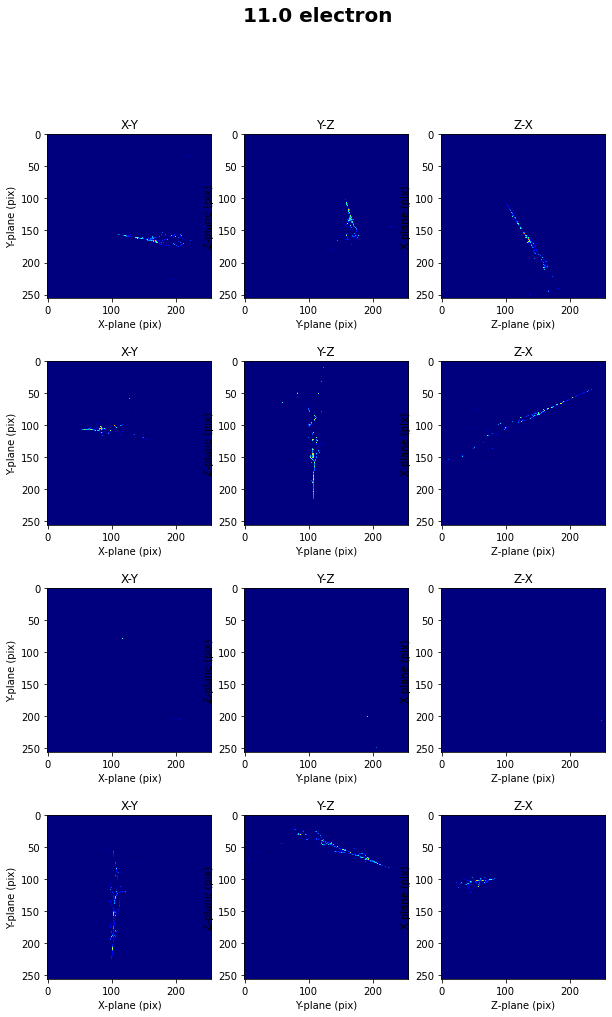

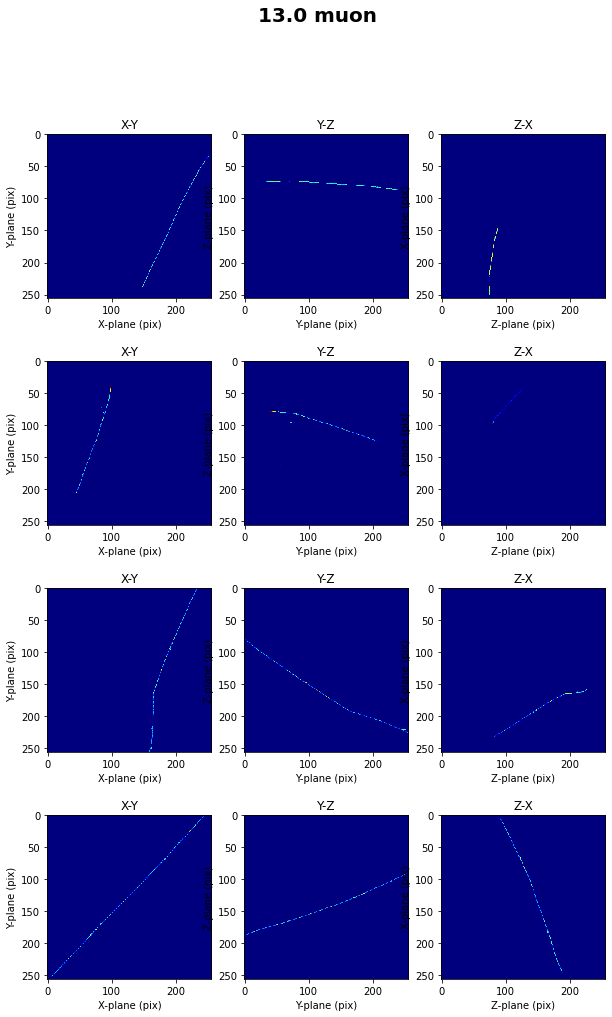

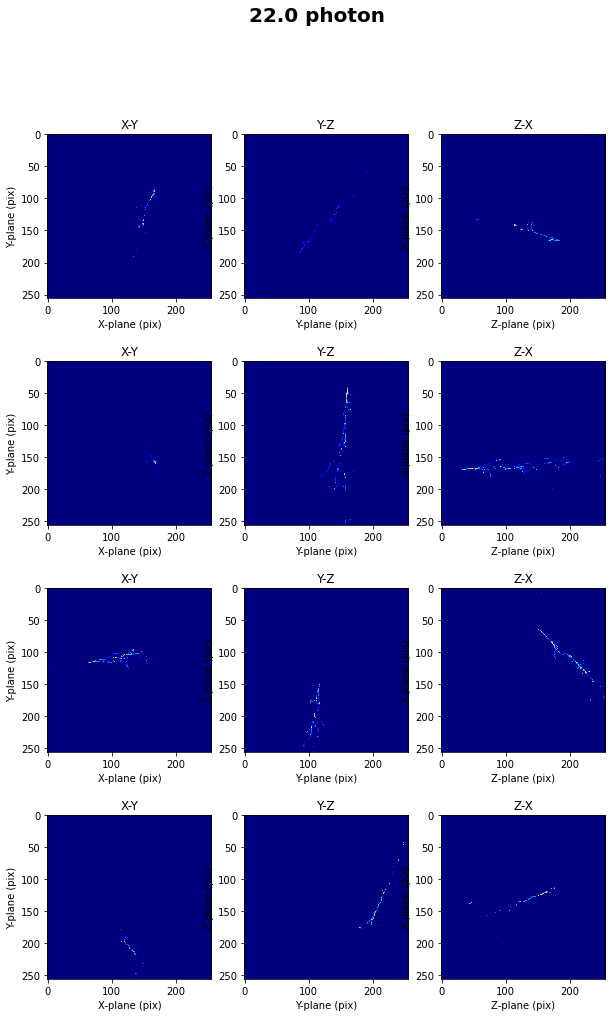

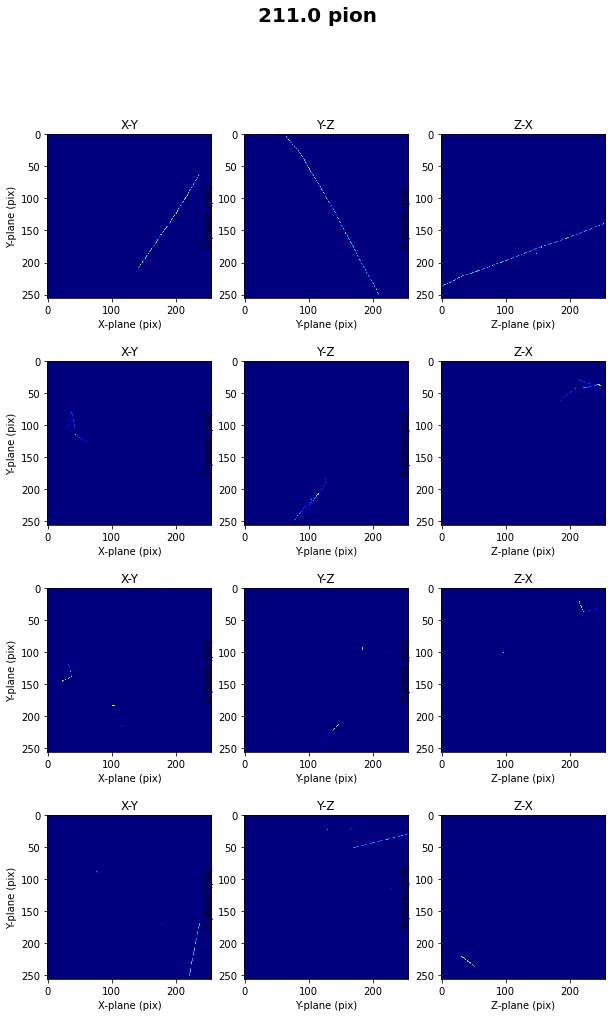

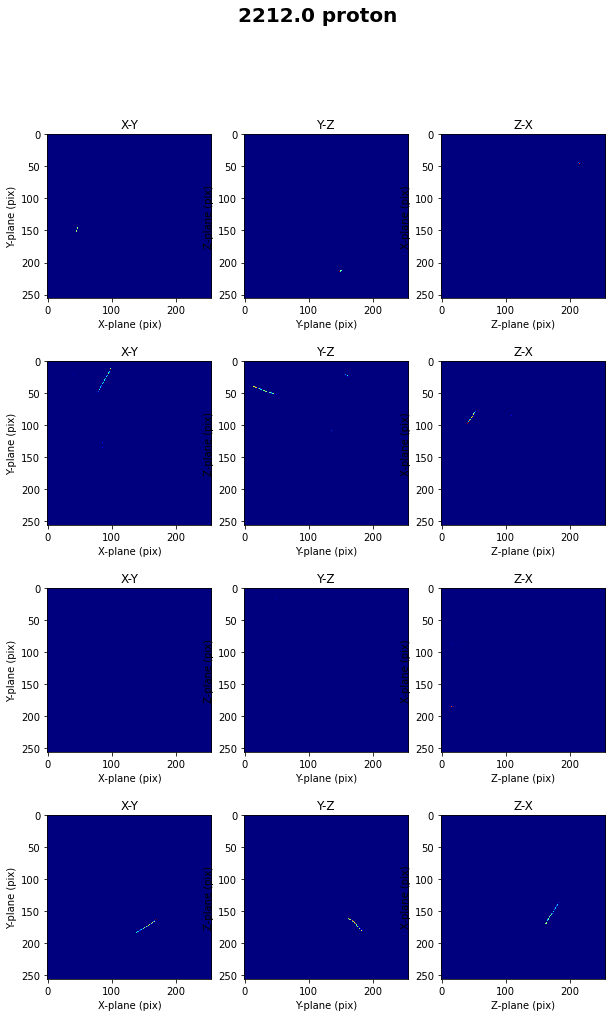

In [186]:
for i, particle_label in enumerate(particle_labels):
    # plot grid for each particle type with particle title ABOVE the corresponding image grid
    plot_one_type_event(all_types_idxs[i], particle_label)

#### By inspecting the first four images of each particle type notice some typical characteristics:
- electrons have a scattered 'shower' track that varies in length and intensity
- muons have long linear tracks, no shower
- photons have similar shower tracks to electrons
- pions have linear tracks, no shower, but unlike muons we see a range of lengths and intensities
- protons have very short tracks

#### We also see there are some images for various particle types that are just low intensity and we don't see any track. Could have consider dropping those from the analysis as they would presumably be nearly impossible to classify.

#### Note: apologies for the y-axis labels overlapping the images.

In [26]:
# here we will plot three more images, for each particle type
# one for the lowest, one for the median and one for the maximum total momentum 
nb_to_plot = 3
all_types_idxs = []

for label in particle_labels:
    # get all the entries for this particle type
    particle_type_idxs = np.where(p_id == label)[0]
    # get the corresponding total momenta
    particle_ptots = p_ptot[particle_type_idxs]
    # minimum total momentum and its index
    min_particle_ptot_i = np.argmin(particle_ptots)
    min_ptot_idx = particle_type_idxs[min_particle_ptot_i]
    # median total momentum and its index
    median_particle_ptot_i = np.argsort(particle_ptots)[len(particle_ptots)//2]
    median_ptot_idx = particle_type_idxs[median_particle_ptot_i]
    # maximum total momentum and its index
    max_particle_ptot_i = np.argmax(particle_ptots)
    max_ptot_idx = particle_type_idxs[max_particle_ptot_i]  
    
    all_types_idxs.append(np.array([min_ptot_idx, median_ptot_idx, max_ptot_idx]))

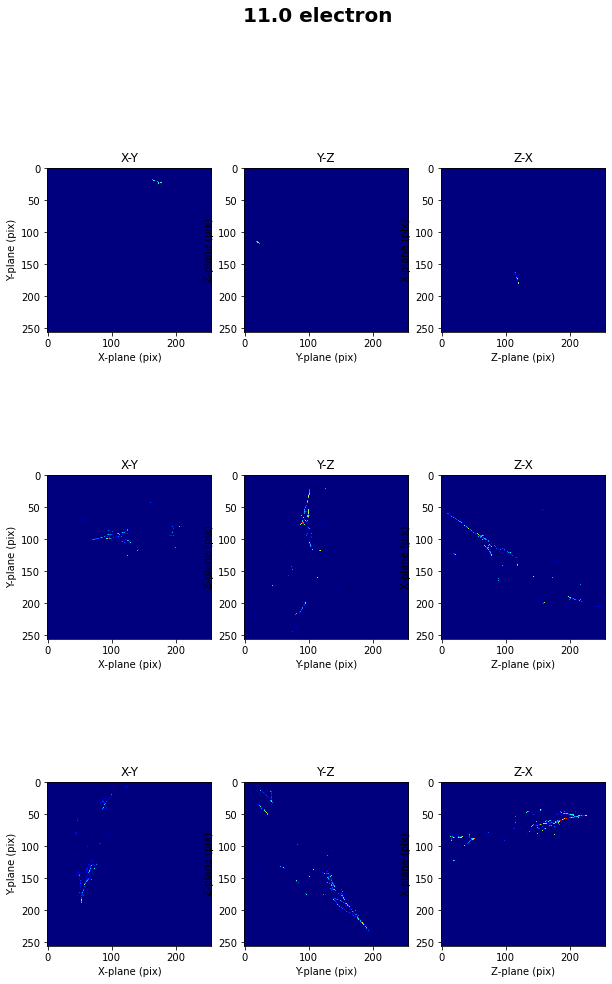

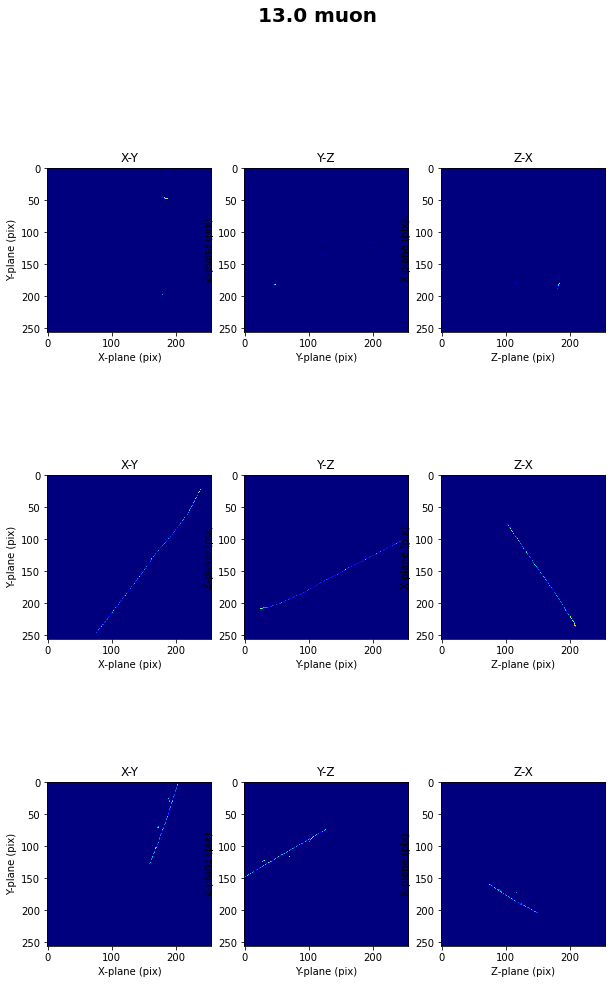

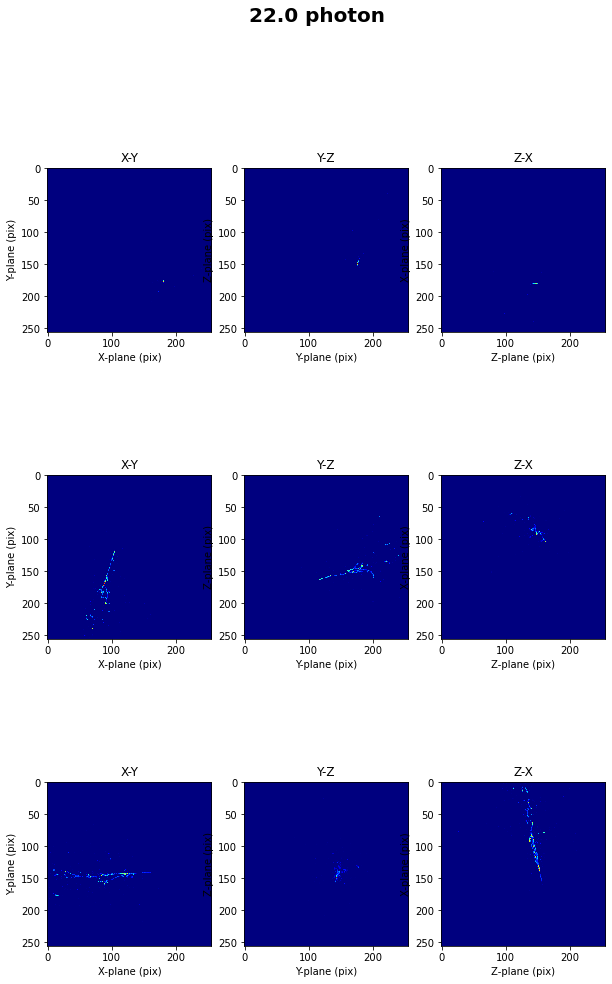

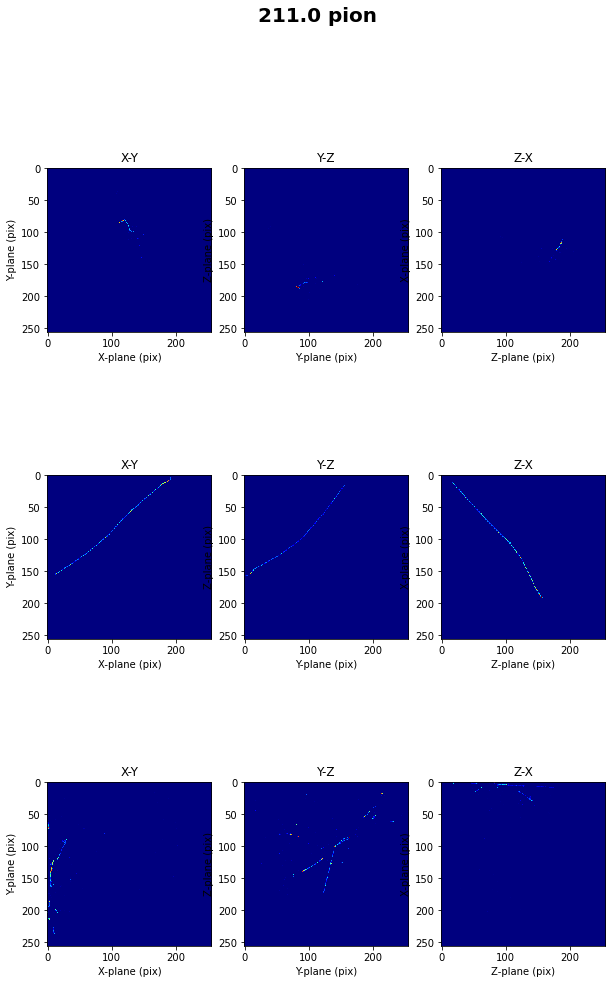

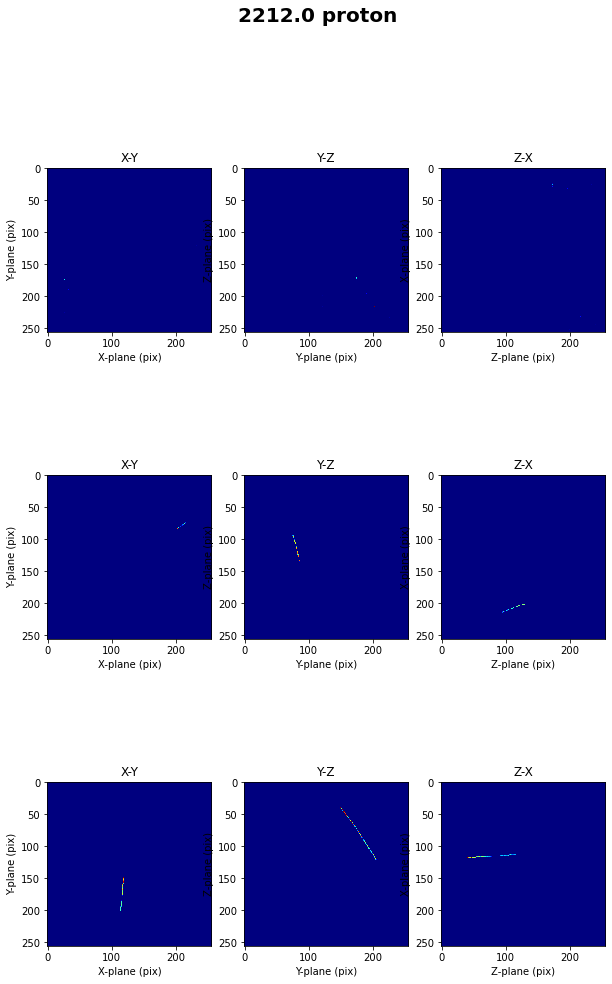

In [27]:
for i, particle_label in enumerate(particle_labels):
    # first row is low, second is median and third is max momentum for each particle type
    plot_one_type_event(all_types_idxs[i], particle_label)

#### By inspecting these images we see get some insight into how they vary by momentum. For all particle types, the lowest momentum tracks are very short and almost invisible. For pions, the highest momentum track is quite scatterd, unlike what we saw previously. The highest momentum proton track is longer than typical protons.

In [28]:
def truth_hists(particle_idxs=None, all=True):
    # given the indices of data points to look at (or just all the data), plots histograms for all the truth atributes
    if not all:
        # if looking at specific indices, make a sub dataframe with just those rows
        sub_df = truth_df.loc[particle_idxs]
    else:
        sub_df = truth_df
    # print out statistics
    print(sub_df.describe())
    fig, axs = plt.subplots(2, 4, figsize=(15,10))
    particle_counts = []
    # plot histograms on a grid
    for code in particle_codes:
        particle_counts.append(sub_df[sub_df['p_id'] == code].shape[0])
    axs[0, 0].bar(['electron', 'muon', 'photon', 'pion', 'proton'], particle_counts)
    axs[0, 0].set_xlabel('p_id')
    axs[0, 1].hist(sub_df['p_ptot'], bins=100, color='blue')
    axs[0, 1].set_xlabel('p_ptot')
    axs[0, 2].hist(sub_df['p_px'], bins=100, color='blue')
    axs[0, 2].set_xlabel('p_px')
    axs[0, 3].hist(sub_df['p_py'], bins=100, color='blue')
    axs[0, 3].set_xlabel('p_py')
    axs[1, 0].hist(sub_df['p_pz'], bins=100, color='blue')
    axs[1, 0].set_xlabel('p_pz')
    axs[1, 1].hist(sub_df['p_x'], bins=100, color='blue')
    axs[1, 1].set_xlabel('p_x')
    axs[1, 2].hist(sub_df['p_y'], bins=100, color='blue')
    axs[1, 2].set_xlabel('p_y')
    axs[1, 3].hist(sub_df['p_z'], bins=100, color='blue')
    axs[1, 3].set_xlabel('p_z')

               p_id        p_ptot          p_px          p_py          p_pz  \
count  90000.000000  90000.000000  90000.000000  90000.000000  90000.000000   
mean     493.800000    469.155022     -0.045593     -0.125227      0.310258   
std      862.448621    208.702474    296.030158    296.455608    296.893502   
min       11.000000     35.046874   -794.837986   -794.168189   -795.663423   
25%       13.000000    298.408917   -195.496687   -193.061903   -195.086549   
50%       22.000000    490.647725     -0.659002     -0.909376      0.549553   
75%      211.000000    647.413308    195.314820    193.872500    195.639982   
max     2212.000000    799.996240    792.563604    798.118910    794.294661   

                p_x           p_y           p_z  
count  90000.000000  90000.000000  90000.000000  
mean      61.632020     63.482845     63.669130  
std       33.299315     33.204333     36.589838  
min      -20.453669     -9.720022     -3.502350  
25%       35.370738     37.288419     

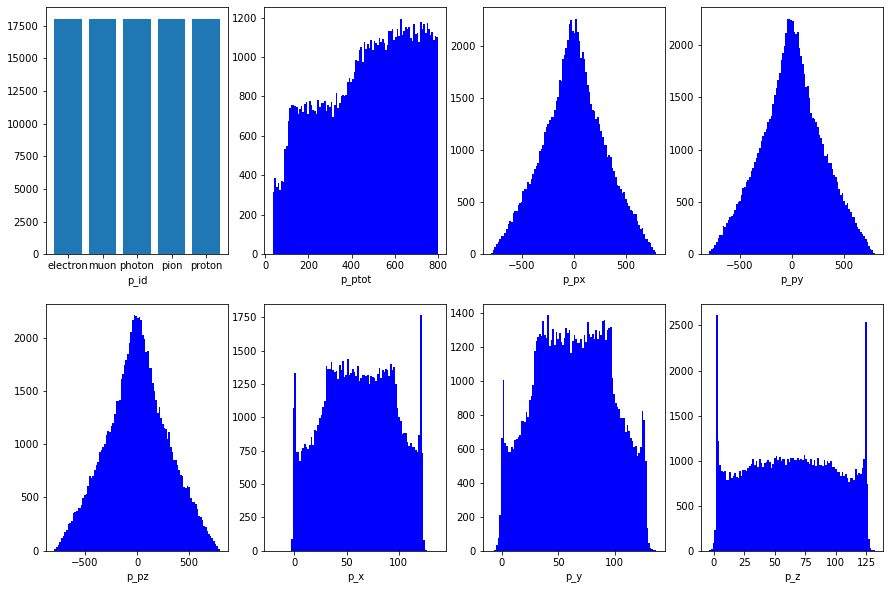

In [29]:
# default parameters make histograms of entire dataset
truth_hists()

#### The statistics table gives us general quantitative insight into the distribution of truth values

#### For each histogram numbered left to right, top to bottom:
1\. 18000 data points for each particle as expected

2\. More higher momentum particles than lower momentum ones

3\. 4\. & 5. Momenta are half distributed in either direction for each cartesian axis so peak is centred on 0 and tailing off at about $\pm 800$

6\. 7\. & 8. Momenta are roughly half distributed in either direction for each cartesian axis but this time there a lot of particles produced on the edges of images (which is in contrast to what is said here http://deeplearnphysics.org/Blog/2017-12-29-BrowsingClassificationData_v0.1.0.html that position is uniformly distributed, but they also say they are looking at 2.56m cubes while our brief implies 1.28m cubes so might be counting production position differently?)

          p_id        p_ptot          p_px          p_py          p_pz  \
count  18000.0  18000.000000  18000.000000  18000.000000  18000.000000   
mean      11.0    415.896163      2.184617      1.456035      2.618427   
std        0.0    220.173474    271.008144    271.168242    272.881308   
min       11.0     35.551400   -793.454820   -794.022026   -792.957790   
25%       11.0    227.993935   -157.564891   -158.172680   -157.525106   
50%       11.0    411.211825      1.245901     -1.373465      1.042919   
75%       11.0    607.863202    159.027435    160.185130    162.830493   
max       11.0    799.973662    792.563604    798.118910    786.597765   

                p_x           p_y           p_z  
count  18000.000000  18000.000000  18000.000000  
mean      61.995832     63.629541     63.394110  
std       32.104667     31.777130     36.439704  
min       -1.900649     -4.704841     -2.432149  
25%       37.269106     38.984426     32.319365  
50%       62.272128     63.708659

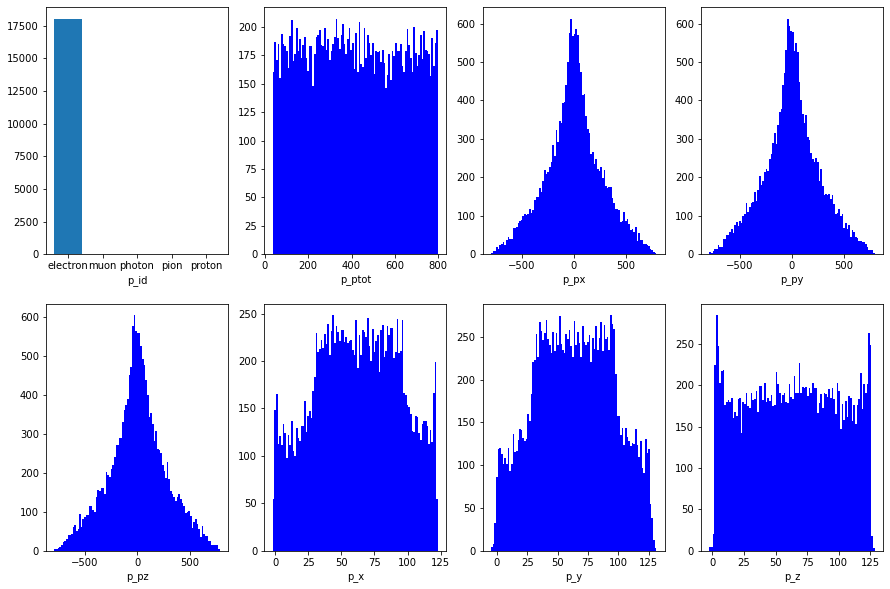

In [30]:
particle_code_choice = 11.
type_idxs = np.where(p_id == particle_code_choice)[0]
truth_hists(particle_idxs=type_idxs, all=False)

          p_id        p_ptot          p_px          p_py          p_pz  \
count  18000.0  18000.000000  18000.000000  18000.000000  18000.000000   
mean      13.0    446.899438     -0.984214     -2.257372     -0.360159   
std        0.0    204.924774    284.511102    282.697206    284.348339   
min       13.0     90.020787   -787.064583   -793.276993   -789.010692   
25%       13.0    269.723631   -179.313043   -181.050891   -179.763871   
50%       13.0    446.636628     -4.097433     -2.464773      1.264409   
75%       13.0    624.903554    180.787983    175.281563    181.671651   
max       13.0    799.912855    785.703330    793.502019    794.294661   

                p_x           p_y           p_z  
count  18000.000000  18000.000000  18000.000000  
mean      62.100279     63.497693     63.791155  
std       35.436781     35.432171     39.698581  
min       -2.023773     -4.962922     -3.487790  
25%       34.640472     35.703931     29.344526  
50%       61.917288     63.687859

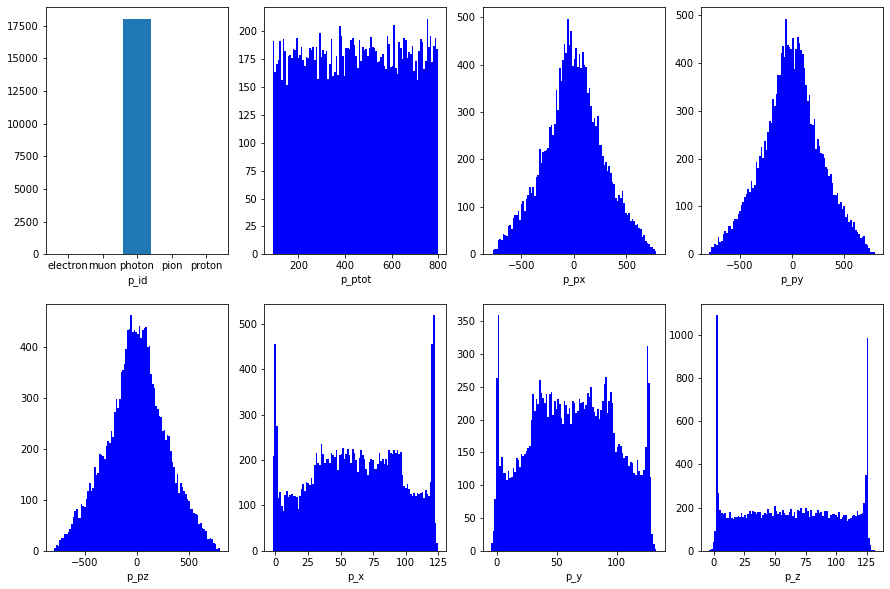

In [31]:
particle_code_choice = 13.
type_idxs = np.where(p_id == particle_code_choice)[0]
truth_hists(particle_idxs=type_idxs, all=False)

          p_id        p_ptot          p_px          p_py          p_pz  \
count  18000.0  18000.000000  18000.000000  18000.000000  18000.000000   
mean      22.0    421.728673     -0.129269      2.552151      0.330849   
std        0.0    221.634581    275.604897    274.721950    274.863591   
min       22.0     35.046874   -788.358996   -787.408422   -795.663423   
25%       22.0    228.907961   -164.437887   -156.057297   -163.128356   
50%       22.0    424.234622      0.462893      2.084627      0.522986   
75%       22.0    615.213453    161.678677    162.546177    163.372342   
max       22.0    799.948612    786.540370    783.096630    788.420957   

                p_x           p_y           p_z  
count  18000.000000  18000.000000  18000.000000  
mean      62.172340     63.359626     63.595155  
std       34.087974     33.382887     38.779296  
min      -20.453669     -9.720022     -3.502350  
25%       36.017642     38.073506     30.236216  
50%       62.510114     63.599637

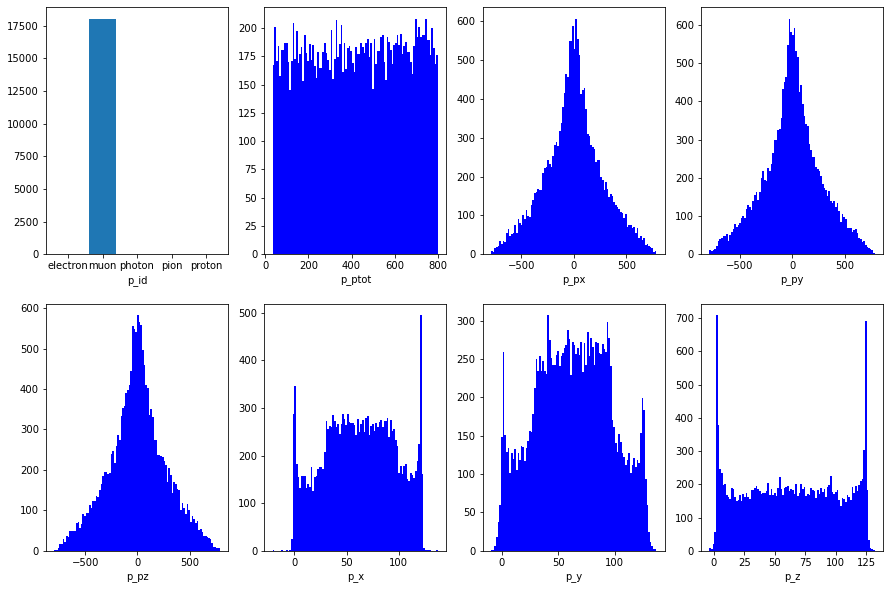

In [32]:
particle_code_choice = 22.
type_idxs = np.where(p_id == particle_code_choice)[0]
truth_hists(particle_idxs=type_idxs, all=False)

          p_id        p_ptot          p_px          p_py          p_pz  \
count  18000.0  18000.000000  18000.000000  18000.000000  18000.000000   
mean     211.0    453.905189      1.730855     -0.179799     -0.155176   
std        0.0    199.719195    284.377185    285.821618    288.724335   
min      211.0    105.053489   -787.910756   -793.285749   -795.464968   
25%      211.0    280.423448   -182.963762   -184.468892   -186.889091   
50%      211.0    454.970960      0.578542     -3.190279     -0.976975   
75%      211.0    625.752867    184.581741    182.421261    184.390104   
max      211.0    799.996240    787.623047    794.550070    793.035464   

                p_x           p_y           p_z  
count  18000.000000  18000.000000  18000.000000  
mean      60.275179     63.314552     63.963843  
std       31.861484     31.953778     34.771503  
min       -1.992975     -5.554606     -2.599335  
25%       34.974067     38.107087     35.625831  
50%       60.046993     63.064568

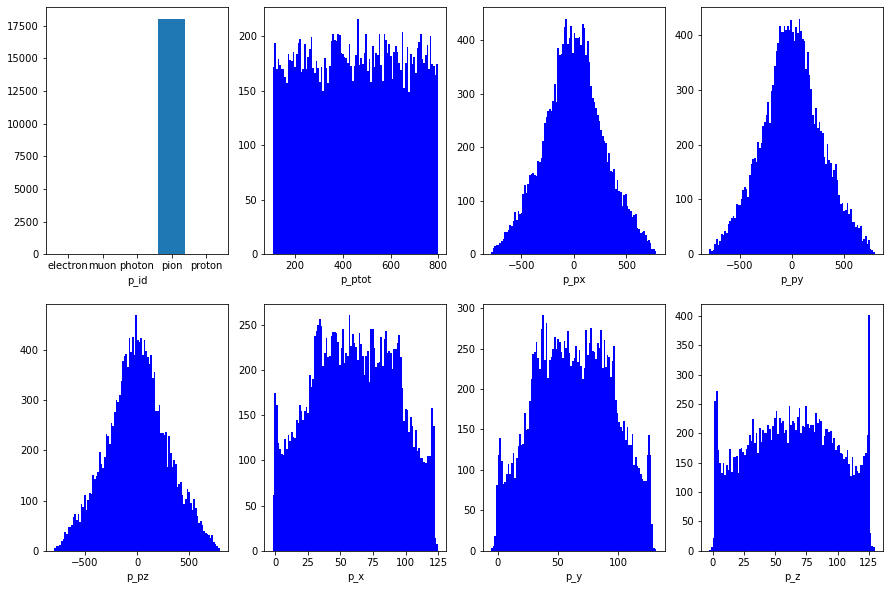

In [33]:
particle_code_choice = 211.
type_idxs = np.where(p_id == particle_code_choice)[0]
truth_hists(particle_idxs=type_idxs, all=False)

          p_id        p_ptot          p_px          p_py          p_pz  \
count  18000.0  18000.000000  18000.000000  18000.000000  18000.000000   
mean    2212.0    607.345648     -3.029955     -2.197148     -0.882651   
std        0.0    115.764682    356.300996    358.907486    355.683858   
min     2212.0    275.567269   -794.837986   -794.168189   -790.578384   
25%     2212.0    514.779861   -291.876386   -293.021677   -291.043181   
50%     2212.0    614.259671     -4.114689      0.078350      0.460630   
75%     2212.0    704.516187    285.041041    291.380914    287.610701   
max     2212.0    799.911232    781.329425    791.987685    789.849917   

                p_x           p_y           p_z  
count  18000.000000  18000.000000  18000.000000  
mean      61.616473     63.612814     63.601386  
std       32.838454     33.348402     32.824848  
min       -2.364226     -2.676424     -0.138815  
25%       33.987789     35.360075     36.463317  
50%       61.393294     63.752311

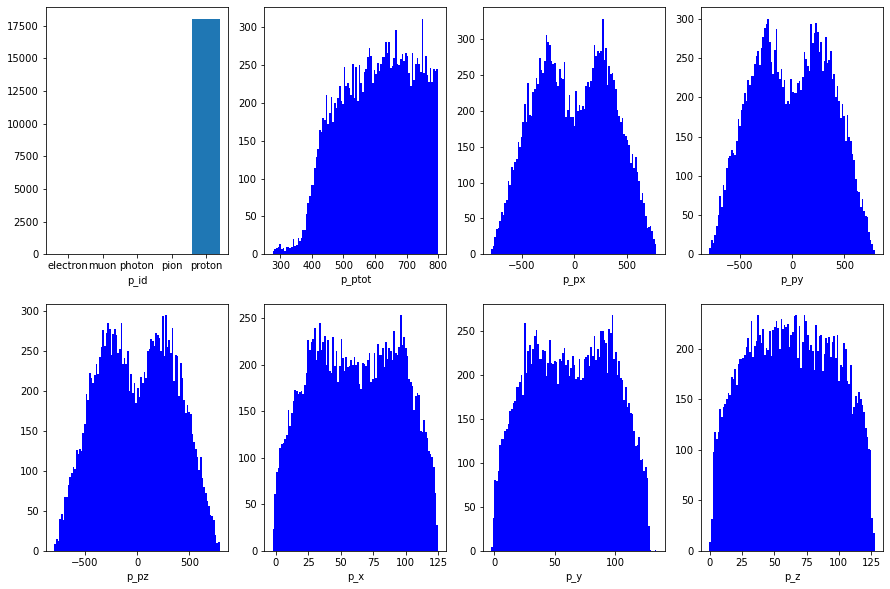

In [34]:
particle_code_choice = 2212.
type_idxs = np.where(p_id == particle_code_choice)[0]
truth_hists(particle_idxs=type_idxs, all=False)

#### Same trends as for whole dataset are found for each particle type inspected individually. We confirm that all cases apart from protons, a roughly uniform total momentum distribution. For protons there are more high momentum particles which is again in contrast to the uniform distribution mentioned here http://deeplearnphysics.org/Blog/2017-12-29-BrowsingClassificationData_v0.1.0.html. This is consistent with the cartesian momentum projecttions peaking either side of zero. Potentially a deliberate feature of out subset of the 'open data'. May mean protons are even easier to classify as a result.

## Task 1: Image classification
* Create an algorithm to identify each event as being from one of five types of particles present in the datase
* You are strongly encouraged to use a convolutional neural network (CNN) classifier on the images, though this is not compulsary.
* Explore different architectures for the model, and explain in detail your choice of model, and the final parameters chosen. Consider doing a robust hyperparameter search.
* Explore the results and documents your findings. Ask as many questions about your model as you can, and document your findings.
    * Which particles are easy to identify, and which are not? 
    * What are the physics reasons for why some particles are similar?
    * Is there a dependence on particle position or momentum in your classifier for certain particle types?
    * Can you come up with a selection which gives good paricle purity?

In [35]:
# input shape to network, planning to use batch funtion given means reshaping images in network instead of in preprocessing
shape = 256 * 256 * 3
nb_classes = 5
# particle truth codes
y_train_codes = truth_train[:, 0]
y_train_labels = np.copy(y_train_codes)
y_test_codes = truth_test[:, 0]
y_test_labels = np.copy(y_test_codes)

# to make labels that are integer encoded instead of the particle physics number labels
current_int = 0
for label in np.unique(y_train_labels):
    y_train_labels[y_train_labels == label] = current_int
    y_test_labels[y_test_labels == label] = current_int
    current_int += 1

In [36]:
def buildCNN(hyper_params):
    # returns a build CNN model
    # read in a set of hyper parameters
    # how many conv2d layers and how many filters in each
    conv_layers = hyper_params['conv_layers']
    # how many dense layers and how many nodes in each
    dense_layers = hyper_params['dense_layers']
    # always one dropout layer, but what fraction of nodes are dropped
    dropout = hyper_params['dropout']
    
    i = Input(shape=shape)
    # reshape back to images ready for 2D concvolutional layers
    x = Reshape((256, 256, 3))(i)
    
    for j, conv_filters in enumerate(conv_layers):
        x = Conv2D(conv_filters, kernel_size=(3,3), padding='same', activation='relu')(x)
        if j != len(conv_layers) - 1:
            # follow each conv layer with a max pooling layer apart from the last one so not lose image resolution too much
            x = MaxPooling2D(pool_size=(2,2))(x)
    
    # flatten ready for dense layers next
    x = Flatten()(x)
    
    # dnese layers
    for dense_nodes in dense_layers:
        x = Dense(dense_nodes, activation='relu')(x)
    
    # one dropout layer applied to final dense layer
    x = Dropout(dropout)(x)
    # output uses softmax fo give a probability between 0 and 1 for each class
    o = Dense(nb_classes, activation='softmax')(x)
    
    name = 'CNN_C{}De{}Dr{}'.format('_'.join([str(int) for int in conv_layers])+'_',
                                    '_'.join([str(int) for int in dense_layers])+'_',
                                    dropout) 
    cnn = Model(i, o, name=name)
    
    return cnn

In [37]:
# quite random hyperparameter choices at first
hyper_params = {'conv_layers': [[8, 16, 24], [64, 64, 64], [8, 8, 8, 8]],
                'dense_layers': [[20], [20, 20], [50]],
                'dropout': [0.1, 0.4]}
# makes a grid of all possible hyperparameter combinations
param_grid = list(ParameterGrid(hyper_params))

models = []
for params in param_grid:
    # build and compile all the models
    model = buildCNN(params)
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    models.append(model)

In [37]:
# train all models using callbacks to reduce training time and save models to a file as recommended
validation_slice = 5000
batch_size = 32
model_histories = []
for model in models:
    callbacks = []
    early_stopping = EarlyStopping(patience=4, monitor="val_loss", min_delta=0.0001, verbose=1)
    callbacks.append(early_stopping)
    model_checkpoint = ModelCheckpoint(model.name, monitor="val_loss", save_best_only=True, verbose=1)
    callbacks.append(model_checkpoint)
    reduce_lr = ReduceLROnPlateau(patience=4, verbose=1, min_lr=1e-4)
    callbacks.append(reduce_lr)
    model_history = model.fit(nn_batch_generator(x_train[:-validation_slice],y_train_labels[:-validation_slice],batch_size=batch_size),
                              epochs=30,
                              steps_per_epoch=int((50000-validation_slice)/batch_size),
                              validation_data=(x_train[-validation_slice:], y_train_labels[-validation_slice:]),
                              callbacks=callbacks)
    model_histories.append(model_history)

Epoch 1/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 32.0000 - loss: 1.4639 - accuracy: 0.3394

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 1.19577, saving model to CNN_C8_16_24_De20_Dr0.1
INFO:tensorflow:Assets written to: CNN_C8_16_24_De20_Dr0.1\assets
1406/1406 [==============================] - 414s 294ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.4639 - accuracy: 0.3394 - val_loss: 1.1958 - val_accuracy: 0.4702 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 1.0153 - accuracy: 0.5377
Epoch 00002: val_loss improved from 1.19577 to 0.90778, saving model to CNN_C8_16_24_De20_Dr0.1
INFO:tensorflow:Assets written to: CNN_C8_16_24_De20_Dr0.1\assets
1406/1406 [==============================] - 375s 267ms/step - batch: 702.5000 - size: 31.9829 - loss: 1.0153 - accuracy: 0.5377 - val_loss: 0.9078 - val_accuracy: 0.5582 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.8603 - accuracy: 0.5839
Epoch 00003: val_loss did not improve from 0.90

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.98799, saving model to CNN_C8_16_24_De20_Dr0.4
INFO:tensorflow:Assets written to: CNN_C8_16_24_De20_Dr0.4\assets
1406/1406 [==============================] - 370s 263ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.3882 - accuracy: 0.3898 - val_loss: 0.9880 - val_accuracy: 0.5650 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.9608 - accuracy: 0.5551
Epoch 00002: val_loss improved from 0.98799 to 0.85768, saving model to CNN_C8_16_24_De20_Dr0.4
INFO:tensorflow:Assets written to: CNN_C8_16_24_De20_Dr0.4\assets
1406/1406 [==============================] - 366s 260ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.9608 - accuracy: 0.5551 - val_loss: 0.8577 - val_accuracy: 0.5798 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.7997 - accuracy: 0.6009
Epoch 00003: val_loss improved from 0.85768 to 

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.82439, saving model to CNN_C8_16_24_De20_20_Dr0.1
INFO:tensorflow:Assets written to: CNN_C8_16_24_De20_20_Dr0.1\assets
1406/1406 [==============================] - 371s 263ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.1801 - accuracy: 0.4687 - val_loss: 0.8244 - val_accuracy: 0.6010 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.7779 - accuracy: 0.6231
Epoch 00002: val_loss improved from 0.82439 to 0.77386, saving model to CNN_C8_16_24_De20_20_Dr0.1
INFO:tensorflow:Assets written to: CNN_C8_16_24_De20_20_Dr0.1\assets
1406/1406 [==============================] - 369s 263ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.7779 - accuracy: 0.6231 - val_loss: 0.7739 - val_accuracy: 0.6210 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.6865 - accuracy: 0.6592
Epoch 00003: val_loss did not impro

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 1.16633, saving model to CNN_C8_16_24_De20_20_Dr0.4
INFO:tensorflow:Assets written to: CNN_C8_16_24_De20_20_Dr0.4\assets
1406/1406 [==============================] - 368s 261ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.4662 - accuracy: 0.3413 - val_loss: 1.1663 - val_accuracy: 0.4952 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 1.0159 - accuracy: 0.5512
Epoch 00002: val_loss improved from 1.16633 to 0.93674, saving model to CNN_C8_16_24_De20_20_Dr0.4
INFO:tensorflow:Assets written to: CNN_C8_16_24_De20_20_Dr0.4\assets
1406/1406 [==============================] - 368s 262ms/step - batch: 702.5000 - size: 31.9829 - loss: 1.0159 - accuracy: 0.5512 - val_loss: 0.9367 - val_accuracy: 0.5712 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.7482 - accuracy: 0.6447
Epoch 00003: val_loss improved from

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.84614, saving model to CNN_C8_16_24_De50_Dr0.1
INFO:tensorflow:Assets written to: CNN_C8_16_24_De50_Dr0.1\assets
1406/1406 [==============================] - 377s 268ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.2711 - accuracy: 0.4594 - val_loss: 0.8461 - val_accuracy: 0.5884 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.8033 - accuracy: 0.6106
Epoch 00002: val_loss improved from 0.84614 to 0.81656, saving model to CNN_C8_16_24_De50_Dr0.1
INFO:tensorflow:Assets written to: CNN_C8_16_24_De50_Dr0.1\assets
1406/1406 [==============================] - 376s 268ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.8033 - accuracy: 0.6106 - val_loss: 0.8166 - val_accuracy: 0.6080 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.6797 - accuracy: 0.6615
Epoch 00003: val_loss improved from 0.81656 to 

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.78343, saving model to CNN_C8_16_24_De50_Dr0.4
INFO:tensorflow:Assets written to: CNN_C8_16_24_De50_Dr0.4\assets
1406/1406 [==============================] - 378s 268ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.0807 - accuracy: 0.5037 - val_loss: 0.7834 - val_accuracy: 0.6272 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.7205 - accuracy: 0.6436
Epoch 00002: val_loss improved from 0.78343 to 0.75500, saving model to CNN_C8_16_24_De50_Dr0.4
INFO:tensorflow:Assets written to: CNN_C8_16_24_De50_Dr0.4\assets
1406/1406 [==============================] - 375s 267ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.7205 - accuracy: 0.6436 - val_loss: 0.7550 - val_accuracy: 0.6272 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.6175 - accuracy: 0.6824
Epoch 00003: val_loss did not improve from 0.75

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.91785, saving model to CNN_C64_64_64_De20_Dr0.1
INFO:tensorflow:Assets written to: CNN_C64_64_64_De20_Dr0.1\assets
1406/1406 [==============================] - 4945s 4s/step - batch: 702.5000 - size: 32.0000 - loss: 1.2716 - accuracy: 0.4507 - val_loss: 0.9179 - val_accuracy: 0.6126 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.8407 - accuracy: 0.6202
Epoch 00002: val_loss improved from 0.91785 to 0.72897, saving model to CNN_C64_64_64_De20_Dr0.1
INFO:tensorflow:Assets written to: CNN_C64_64_64_De20_Dr0.1\assets
1406/1406 [==============================] - 4935s 4s/step - batch: 702.5000 - size: 31.9829 - loss: 0.8407 - accuracy: 0.6202 - val_loss: 0.7290 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.6852 - accuracy: 0.6635
Epoch 00003: val_loss did not improve from 0.72

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.79101, saving model to CNN_C64_64_64_De20_Dr0.4
INFO:tensorflow:Assets written to: CNN_C64_64_64_De20_Dr0.4\assets
1406/1406 [==============================] - 4965s 4s/step - batch: 702.5000 - size: 32.0000 - loss: 1.0423 - accuracy: 0.4987 - val_loss: 0.7910 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.7531 - accuracy: 0.6295
Epoch 00002: val_loss improved from 0.79101 to 0.68846, saving model to CNN_C64_64_64_De20_Dr0.4
INFO:tensorflow:Assets written to: CNN_C64_64_64_De20_Dr0.4\assets
1406/1406 [==============================] - 4952s 4s/step - batch: 702.5000 - size: 31.9829 - loss: 0.7531 - accuracy: 0.6295 - val_loss: 0.6885 - val_accuracy: 0.6464 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.6454 - accuracy: 0.6768
Epoch 00003: val_loss improved from 0.68846 to 

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.92719, saving model to CNN_C64_64_64_De20_20_Dr0.1
INFO:tensorflow:Assets written to: CNN_C64_64_64_De20_20_Dr0.1\assets
1406/1406 [==============================] - 4950s 4s/step - batch: 702.5000 - size: 32.0000 - loss: 1.2085 - accuracy: 0.4306 - val_loss: 0.9272 - val_accuracy: 0.5480 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.8607 - accuracy: 0.5661
Epoch 00002: val_loss improved from 0.92719 to 0.81368, saving model to CNN_C64_64_64_De20_20_Dr0.1
INFO:tensorflow:Assets written to: CNN_C64_64_64_De20_20_Dr0.1\assets
1406/1406 [==============================] - 4938s 4s/step - batch: 702.5000 - size: 31.9829 - loss: 0.8607 - accuracy: 0.5661 - val_loss: 0.8137 - val_accuracy: 0.5688 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.7517 - accuracy: 0.5917
Epoch 00003: val_loss improved from

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.71974, saving model to CNN_C64_64_64_De20_20_Dr0.4
INFO:tensorflow:Assets written to: CNN_C64_64_64_De20_20_Dr0.4\assets
1406/1406 [==============================] - 4978s 4s/step - batch: 702.5000 - size: 32.0000 - loss: 1.0870 - accuracy: 0.5073 - val_loss: 0.7197 - val_accuracy: 0.6286 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.6778 - accuracy: 0.6576
Epoch 00002: val_loss improved from 0.71974 to 0.67228, saving model to CNN_C64_64_64_De20_20_Dr0.4
INFO:tensorflow:Assets written to: CNN_C64_64_64_De20_20_Dr0.4\assets
1406/1406 [==============================] - 5003s 4s/step - batch: 702.5000 - size: 31.9829 - loss: 0.6778 - accuracy: 0.6576 - val_loss: 0.6723 - val_accuracy: 0.6502 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.5891 - accuracy: 0.6942
Epoch 00003: val_loss did not impro

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.71993, saving model to CNN_C64_64_64_De50_Dr0.1
INFO:tensorflow:Assets written to: CNN_C64_64_64_De50_Dr0.1\assets
1406/1406 [==============================] - 5041s 4s/step - batch: 702.5000 - size: 32.0000 - loss: 1.0098 - accuracy: 0.5387 - val_loss: 0.7199 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.6763 - accuracy: 0.6629
Epoch 00002: val_loss did not improve from 0.71993
1406/1406 [==============================] - 4969s 4s/step - batch: 702.5000 - size: 31.9829 - loss: 0.6763 - accuracy: 0.6629 - val_loss: 0.7517 - val_accuracy: 0.6330 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.5653 - accuracy: 0.7170
Epoch 00003: val_loss did not improve from 0.71993
1406/1406 [==============================] - 4997s 4s/step - batch: 702.5000 - size: 31.9829 - loss: 0.5653 -

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.68861, saving model to CNN_C64_64_64_De50_Dr0.4
INFO:tensorflow:Assets written to: CNN_C64_64_64_De50_Dr0.4\assets
1406/1406 [==============================] - 4950s 4s/step - batch: 702.5000 - size: 32.0000 - loss: 0.9813 - accuracy: 0.5595 - val_loss: 0.6886 - val_accuracy: 0.6490 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.6390 - accuracy: 0.6908
Epoch 00002: val_loss did not improve from 0.68861
1406/1406 [==============================] - 4951s 4s/step - batch: 702.5000 - size: 31.9829 - loss: 0.6390 - accuracy: 0.6908 - val_loss: 0.6906 - val_accuracy: 0.6620 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.5308 - accuracy: 0.7490
Epoch 00003: val_loss did not improve from 0.68861
1406/1406 [==============================] - 4968s 4s/step - batch: 702.5000 - size: 31.9829 - loss: 0.5308 -

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 1.08859, saving model to CNN_C8_8_8_8_De20_Dr0.1
INFO:tensorflow:Assets written to: CNN_C8_8_8_8_De20_Dr0.1\assets
1406/1406 [==============================] - 312s 221ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.4659 - accuracy: 0.3637 - val_loss: 1.0886 - val_accuracy: 0.5344 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 1.0144 - accuracy: 0.5468 - ETA: 12s - batch: 672.0000 - size: 31.9822 - lo
Epoch 00002: val_loss improved from 1.08859 to 0.89031, saving model to CNN_C8_8_8_8_De20_Dr0.1
INFO:tensorflow:Assets written to: CNN_C8_8_8_8_De20_Dr0.1\assets
1406/1406 [==============================] - 316s 225ms/step - batch: 702.5000 - size: 31.9829 - loss: 1.0144 - accuracy: 0.5468 - val_loss: 0.8903 - val_accuracy: 0.5902 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.8567 - accuracy: 0.60

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 1.02381, saving model to CNN_C8_8_8_8_De20_Dr0.4
INFO:tensorflow:Assets written to: CNN_C8_8_8_8_De20_Dr0.4\assets
1406/1406 [==============================] - 323s 228ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.3465 - accuracy: 0.4127 - val_loss: 1.0238 - val_accuracy: 0.5514 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.9555 - accuracy: 0.5589 ETA: 6s - batch
Epoch 00002: val_loss improved from 1.02381 to 0.84432, saving model to CNN_C8_8_8_8_De20_Dr0.4
INFO:tensorflow:Assets written to: CNN_C8_8_8_8_De20_Dr0.4\assets
1406/1406 [==============================] - 350s 249ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.9555 - accuracy: 0.5589 - val_loss: 0.8443 - val_accuracy: 0.5832 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.8075 - accuracy: 0.5977 - ETA: 22s - batch: 648.5000 - 

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 1.02724, saving model to CNN_C8_8_8_8_De20_20_Dr0.1
INFO:tensorflow:Assets written to: CNN_C8_8_8_8_De20_20_Dr0.1\assets
1406/1406 [==============================] - 306s 216ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.3909 - accuracy: 0.3865 - val_loss: 1.0272 - val_accuracy: 0.5408 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.9084 - accuracy: 0.5664
Epoch 00002: val_loss improved from 1.02724 to 0.80152, saving model to CNN_C8_8_8_8_De20_20_Dr0.1
INFO:tensorflow:Assets written to: CNN_C8_8_8_8_De20_20_Dr0.1\assets
1406/1406 [==============================] - 301s 214ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.9084 - accuracy: 0.5664 - val_loss: 0.8015 - val_accuracy: 0.5898 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.7735 - accuracy: 0.6096
Epoch 00003: val_loss improved from

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.83548, saving model to CNN_C8_8_8_8_De20_20_Dr0.4
INFO:tensorflow:Assets written to: CNN_C8_8_8_8_De20_20_Dr0.4\assets
1406/1406 [==============================] - 310s 219ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.2188 - accuracy: 0.4476 - val_loss: 0.8355 - val_accuracy: 0.5924 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.8256 - accuracy: 0.6031 - ETA: 19s 
Epoch 00002: val_loss improved from 0.83548 to 0.74913, saving model to CNN_C8_8_8_8_De20_20_Dr0.4
INFO:tensorflow:Assets written to: CNN_C8_8_8_8_De20_20_Dr0.4\assets
1406/1406 [==============================] - 304s 216ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.8256 - accuracy: 0.6031 - val_loss: 0.7491 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.7225 - accuracy: 0.6438 - ETA: 33s - - ETA: 20s

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.75830, saving model to CNN_C8_8_8_8_De50_Dr0.1
INFO:tensorflow:Assets written to: CNN_C8_8_8_8_De50_Dr0.1\assets
1406/1406 [==============================] - 302s 214ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.0728 - accuracy: 0.5184 - val_loss: 0.7583 - val_accuracy: 0.6296 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.7405 - accuracy: 0.6392
Epoch 00002: val_loss improved from 0.75830 to 0.70589, saving model to CNN_C8_8_8_8_De50_Dr0.1
INFO:tensorflow:Assets written to: CNN_C8_8_8_8_De50_Dr0.1\assets
1406/1406 [==============================] - 300s 213ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.7405 - accuracy: 0.6392 - val_loss: 0.7059 - val_accuracy: 0.6460 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.6774 - accuracy: 0.6608
Epoch 00003: val_loss improved from 0.70589 to 

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.94804, saving model to CNN_C8_8_8_8_De50_Dr0.4
INFO:tensorflow:Assets written to: CNN_C8_8_8_8_De50_Dr0.4\assets
1406/1406 [==============================] - 304s 215ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.3440 - accuracy: 0.4451 - val_loss: 0.9480 - val_accuracy: 0.5830 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.8220 - accuracy: 0.6097 - ETA: 17s - batch: 658.5000 - size: - ETA: 9s - batch: 678.5000 - size: 31.9823 - loss: 0.8240 
Epoch 00002: val_loss improved from 0.94804 to 0.74160, saving model to CNN_C8_8_8_8_De50_Dr0.4
INFO:tensorflow:Assets written to: CNN_C8_8_8_8_De50_Dr0.4\assets
1406/1406 [==============================] - 301s 214ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.8220 - accuracy: 0.6097 - val_loss: 0.7416 - val_accuracy: 0.6382 - lr: 0.0010
Epoch 3/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 

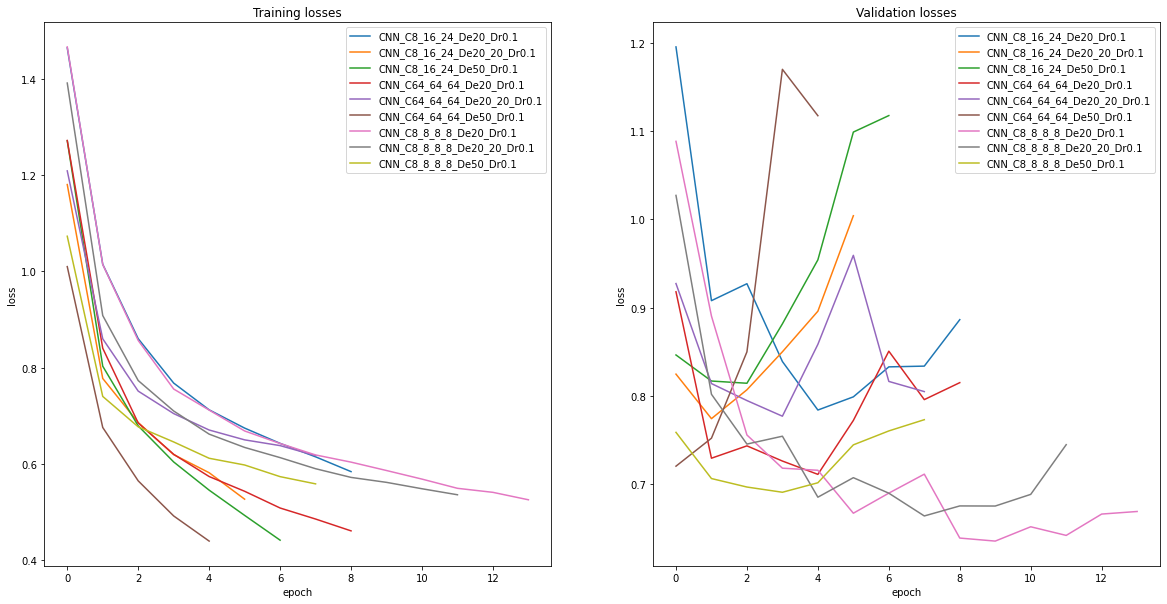

In [95]:
# plot training and validation losses for all models
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
for i, model_history in enumerate(model_histories):
    if models[i].name[-1] == '1':
        plt.title('Training losses')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.plot(model_history.history['loss'], label=models[i].name)
        plt.legend(loc='best')
plt.subplot(1, 2, 2)
for i, model_history in enumerate(model_histories):
    if models[i].name[-1] == '1':
        plt.title('Validation losses')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.plot(model_history.history['val_loss'], label=models[i].name)
        plt.legend(loc='best')

#### Likely due to the naive hyperparameter choices, we have some bizarre validation curves. The spikiness in validation losses mean a lot of models were earlystopped withing the first few epochs. Only really the grey and pink curves look okay and trained for a reasonble mount of time.

#### Note: Here I could go back and refine the hyperparameter grid but these already took several days to train on my laptop so have not done that. Also, you'll notice I built model with dropout 0.4 but didn't train those because it would have taken several more days. The triple 64 filter conv2d models took the bulk of the time so regret doing those.

In [57]:
# evaluate accuracy on test set for each model
for model in models:
    if model.name[-1] == '1':
        _, acc = model.evaluate(nn_batch_generator(x_test, y_test_labels,batch_size=50),steps=40000/50)
        print("{} testing accuray: {}".format(model.name, acc * 100.))

CNN_C8_16_24_De20_Dr0.1 testing accuray: 62.8974974155426
CNN_C8_16_24_De20_20_Dr0.1 testing accuray: 60.01499891281128
CNN_C8_16_24_De50_Dr0.1 testing accuray: 60.509997606277466
CNN_C64_64_64_De20_Dr0.1 testing accuray: 64.37000036239624
CNN_C64_64_64_De20_20_Dr0.1 testing accuray: 63.042497634887695
CNN_C64_64_64_De50_Dr0.1 testing accuray: 63.93250226974487
CNN_C8_8_8_8_De20_Dr0.1 testing accuray: 69.53250169754028
CNN_C8_8_8_8_De20_20_Dr0.1 testing accuray: 66.61999821662903
CNN_C8_8_8_8_De50_Dr0.1 testing accuray: 65.70500135421753


Based on accuracy alone, 'CNN_C8_8_8_8_De20_Dr0.1' was the best and was one of the better loss curves too so that is the model I will bring forward. The more complex 64 filter layer CNN's were surprisingly poor just like their loss curves

In [85]:
# One more model
best_params = {'conv_layers': [16, 16, 32, 32], 'dense_layers': [20], 'dropout': 0.2}
best_cnn = buildCNN(best_params)
best_cnn.compile(optimizer='adam', 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])

#### Tried one more. This time 4 conv layers just like our current best model but also scaled up the filters to two 16's and two 32's still surprised that arguably the simples set of hyperparameters was best.

In [86]:
best_cnn.summary()

Model: "CNN_C16_16_32_32_De20_Dr0.2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 196608)]          0         
_________________________________________________________________
reshape_28 (Reshape)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 64,

In [87]:
callbacks = []
early_stopping = EarlyStopping(patience=4, monitor="val_loss", min_delta=0.0001, verbose=1)
callbacks.append(early_stopping)
model_checkpoint = ModelCheckpoint(best_cnn.name, monitor="val_loss", save_best_only=True, verbose=1)
callbacks.append(model_checkpoint)
reduce_lr = ReduceLROnPlateau(patience=4, verbose=1, min_lr=1e-4)
callbacks.append(reduce_lr)
best_cnn_history = best_cnn.fit(nn_batch_generator(x_train[:-validation_slice],y_train_labels[:-validation_slice],batch_size=batch_size),
                          epochs=20,
                          steps_per_epoch=int((50000-validation_slice)/batch_size),
                          validation_data=(x_train[-validation_slice:], y_train_labels[-validation_slice:]),
                          callbacks=callbacks)

Epoch 1/20
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 32.0000 - loss: 1.0615 - accuracy: 0.5021

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.79581, saving model to CNN_C16_16_32_32_De20_Dr0.2
INFO:tensorflow:Assets written to: CNN_C16_16_32_32_De20_Dr0.2\assets
1406/1406 [==============================] - 593s 420ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.0615 - accuracy: 0.5021 - val_loss: 0.7958 - val_accuracy: 0.6176 - lr: 0.0010
Epoch 2/20
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.7741 - accuracy: 0.6162
Epoch 00002: val_loss improved from 0.79581 to 0.67449, saving model to CNN_C16_16_32_32_De20_Dr0.2
INFO:tensorflow:Assets written to: CNN_C16_16_32_32_De20_Dr0.2\assets
1406/1406 [==============================] - 582s 414ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.7741 - accuracy: 0.6162 - val_loss: 0.6745 - val_accuracy: 0.6510 - lr: 0.0010
Epoch 3/20
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.6717 - accuracy: 0.6606
Epoch 00003: val_loss did not i

In [88]:
_, acc = best_cnn.evaluate(nn_batch_generator(x_test, y_test_labels,batch_size=50),steps=40000/50)
print("{} testing accuray: {}".format(best_cnn.name, acc * 100.))

CNN_C16_16_32_32_De20_Dr0.2 testing accuray: 66.49749875068665


#### Proposed 'best' model shows decrease in accuracy compared to CNN_C8_8_8_8_De20_Dr0.1 so we still bring forward CNN_C8_8_8_8_De20_Dr0.1.

In [98]:
models[12].name

'CNN_C8_8_8_8_De20_Dr0.1'

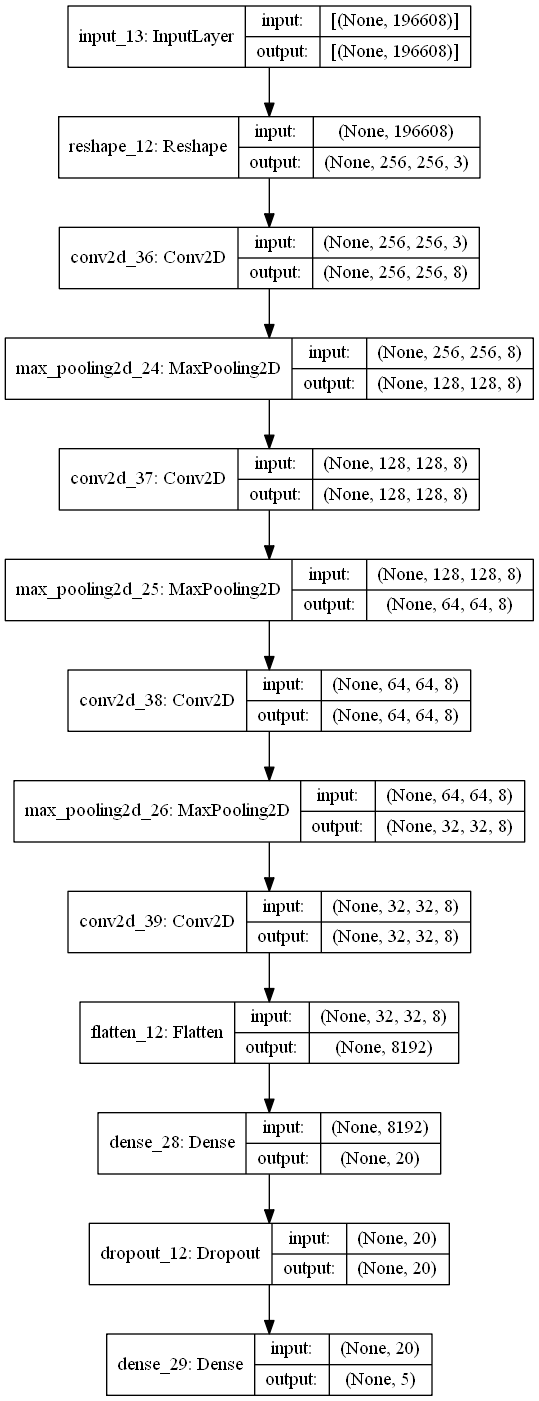

In [188]:
plot_model(models[12], show_shapes=True)

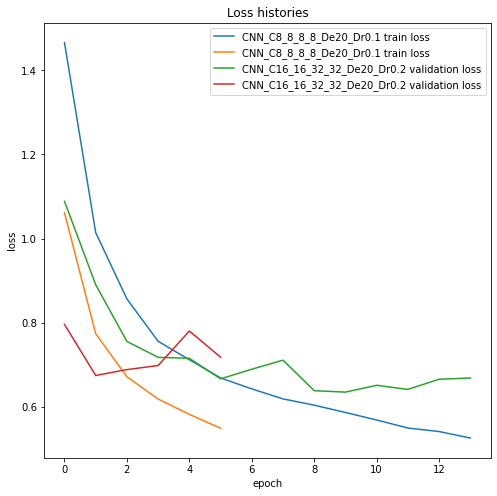

In [198]:
fig = plt.figure(figsize=(8, 8))
plt.title('Loss histories')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(model_histories[12].history['loss'], label=models[12].name + ' train loss')
plt.plot(best_cnn_history.history['loss'], label=models[12].name + ' train loss')
plt.plot(model_histories[12].history['val_loss'], label=best_cnn.name + ' validation loss')
plt.plot(best_cnn_history.history['val_loss'], label=best_cnn.name + ' validation loss')
plt.legend(loc='best')
fig.savefig('Final_cnn.png')

#### The loss curve comparison agrees.

In [122]:
# predict using given batch generator function on test set just for our best model, CNN_C8_8_8_8_De20_Dr0.1
p_test   = models[12].predict(nn_batch_generator(x_test, y_test_labels, batch_size=50), steps=40000/50)
#Pick the index of the highest class per image
py_test  = p_test.argmax(axis=-1)

In [117]:
y_test_codes

array([  13.,   11.,   11., ...,   11., 2212.,  211.])

In [118]:
# just a reminder that the labels are integer encoded in numberical order ie 11., 13., 22., 211., 2212. 
y_test_labels

array([1., 0., 0., ..., 0., 4., 3.])

In [52]:
#tick names for plotting
tick_names = [11., 13., 22., 211., 2212.]
for i, tick_name in enumerate(tick_names):
    tick_names[i] = particle_name(tick_name)
tick_names

['electron', 'muon', 'photon', 'pion', 'proton']

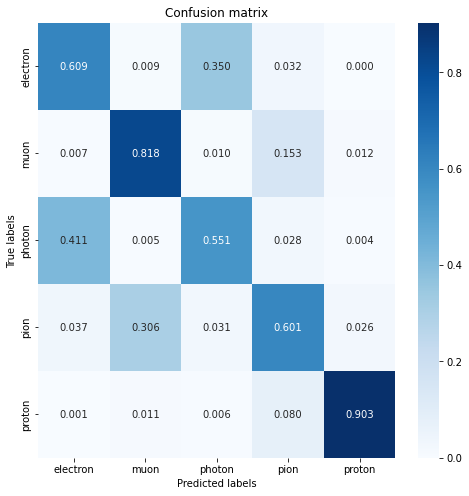

In [199]:
# plot confusion matrix on test set normalised to give probilities summing to 1
cm = confusion_matrix(y_test_labels, py_test, normalize="true")
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, cmap=plt.cm.Blues,annot=True,fmt=".3f")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
ax.set_yticklabels(tick_names)
ax.set_xticklabels(tick_names)
plt.title('Confusion matrix')
fig.savefig('cnn_confusion.png')
plt.show()

#### We see success depends on particle type. High degree of confusion between electron and photon. For example when true label is photon, there is 41% for model to predict electron. This is in agreement with what we guessed from visualising the images in part 0 ourselves. We see something similar for muons and pions. Contrastingly, protons are classified with 90% accuracy, again in agreement with what we guessed from the images and distributions discussed in part 0.

#### It is also physically intuitive as photons and electrons are fundamental particles with much lower mass than the others (pions and muons also have similar masses), while protons are hadrons with much greater mass so should be distinct from the rest.

In [108]:
# kernel died so had to load back in the model
best_model = load_model("CNN_C8_8_8_8_De20_Dr0.1")

#### Below I split the test set into high and low total momentum sets so we get a set with roughly the top half highest momentum electrons, muons etc.

In [140]:
# initialise hits
hits = np.zeros(len(y_test_labels))
for i in range(5):
    # for one particle type get the momentum values for test set
    part_ptot_subset = truth_test[y_test_labels==float(i)][:, 1]
    # mean momentum for that particle type
    mean_ptot = np.mean(part_ptot_subset)
    # add one's to hits at index position if momentum of data point was above average for its particle type
    hits += (((y_test_labels==float(i))*truth_test[:, 1]) > mean_ptot)
# hits is now a boolean array with true where any particle had momentum above the mean for its type
hits = np.array(hits, dtype=bool)    

# make new test sets for high and low momentum
high_ptot_x_test = x_test[hits]
high_ptot_y_test_labels = y_test_labels[hits]
low_ptot_x_test = x_test[np.invert(hits)]
low_ptot_y_test_labels = y_test_labels[np.invert(hits)]

In [142]:
# evaluate accuracy on new sets
_, high_ptot_acc = best_model.evaluate(nn_batch_generator(high_ptot_x_test, high_ptot_y_test_labels,batch_size=50),
                                       steps=high_ptot_y_test_labels.size/50)
print("{} high total momentum testing accuracy: {}".format(best_model.name, high_ptot_acc * 100.))

_, low_ptot_acc = best_model.evaluate(nn_batch_generator(low_ptot_x_test, low_ptot_y_test_labels,batch_size=50),
                                       steps=low_ptot_y_test_labels.size/50)
print("{} low total momentum testing accuracy: {}".format(best_model.name, low_ptot_acc * 100.))

CNN_C8_8_8_8_De20_Dr0.1 high total momentum testing accuracy: 72.75620102882385
CNN_C8_8_8_8_De20_Dr0.1 low total momentum testing accuracy: 63.25104236602783


#### We see slight increased accuracy for high momentum particles and decreased accuracy for low momentum particles. This is understandable as some of the low momentum tracks are almost invisible while high momentum tracks make the particle characteristics more clear.

#### Note: Could go futher here by precentiling the splitting to further maximise accuracy until we have too few particles in the high momentum set to evaulate reliably on.

## Task 2: Choose from one (or several) of these

* Create a variational autoencoder (VAE) on the images for image generation of a paricular type. Try and make it conditional on momentum and position.

In [38]:
def sampling (args):
    # function to sample encoded z to bring forward to decoder
    # Unpack arguments
    z_mean, z_log_var = args

    # Get shape of random noise to sample
    epsilon = K.random_normal(shape=K.shape(z_mean))

    # Return samples from latent space p.d.f.
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [39]:
# randomly choose 2 latent dimensions at first
latent_dim = 2

In [40]:
def buildVAE(hyper_params):
    # similar function to build CNN, returns built VAE model
    # built in same way, conv2d layers, dense followed by dropout
    conv_layers = hyper_params['conv_layers']
    dense_layers = hyper_params['dense_layers']
    dropout = hyper_params['dropout']
    
    surname = 'VAE_C{}De{}Dr{}'.format('_'.join([str(int) for int in conv_layers])+'_',
                                       '_'.join([str(int) for int in dense_layers])+'_',
                                       dropout)
    
    inputs = Input(shape=shape)
    x = Reshape((256, 256, 3))(inputs)
    x = Conv2D(3, kernel_size=(3,3), padding='same', activation='relu')(x)
    
    for j, conv_filters in enumerate(conv_layers):
        x = Conv2D(conv_filters, kernel_size=(3,3), padding='same', activation='relu')(x)
        if j != len(conv_layers) - 1:
            x = MaxPooling2D(pool_size=(2,2))(x)
    
    x = Flatten(name='Flatten')(x)
    
    for dense_nodes in dense_layers:
        x = Dense(dense_nodes, activation='relu')(x)
        
    x = Dropout(dropout)(x)
    # Means and log(variances) layers both connected to previous dense layer
    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)
    # Lambda layer to sample z vector from distribution given by learned means and log(variances) using 'reparameterization trick'
    z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])
    
    # instatiate encoder model to use on its own later
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    
    for layer in encoder.layers:
        if layer.name == 'Flatten':
            # to know what shape to remake for conv transpose layers in decoder
            pre_flat_shape = layer.input_shape[1:]
    
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    
    for dense_nodes in dense_layers:
        x = Dense(dense_nodes, activation='relu')(latent_inputs)
        
    x = Dense(np.prod(pre_flat_shape), activation='relu')(x)
    x = Reshape(pre_flat_shape)(x)
    # Conv transposes and upsampling in order to output correct shaped images at the end
    for j in range(len(conv_layers)):
        x = Conv2DTranspose(conv_layers[-(j+1)], kernel_size=(3,3), padding='same', activation='relu')(x)
        if j != len(conv_layers) - 1:
            x = UpSampling2D(size=(2,2))(x)
    # Sigmoid activated final layer to get pixel values in range 0 to 1
    x = Conv2DTranspose(3, kernel_size=(3,3), padding='same', activation='sigmoid')(x)
    outputs = Flatten()(x)

    decoder = Model(latent_inputs, outputs, name='decoder')
    
    i = encoder.inputs
    if len(i) == 1:
     i = i[0]
     pass
    z = encoder(i)[2]
    o = decoder(z)
    
    vae = Model(i, o, name='VAE_' + surname)
    
    return encoder, decoder, vae

In [41]:
def compile_vae (vae):
    # complie VAE, copied from checkpoint 3
    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        #reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        # here we have flattened values so no need for axis argument
        reco_loss_value = K.sum(reco_loss_value)
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

In [42]:
# hyperparameter grid
vae_hyper_params = {'conv_layers': [[8, 8, 8, 8], [8, 16, 32]],
                    'dense_layers': [[20], [50, 20]],
                    'dropout': [0.1]}

vae_param_grid = list(ParameterGrid(vae_hyper_params))

encoders = []
decoders = []
vae_models = []
for params in vae_param_grid:
    encoder, decoder, vae = buildVAE(params)
    encoders.append(encoder)
    decoders.append(decoder)
    compile_vae(vae)
    vae_models.append(vae)

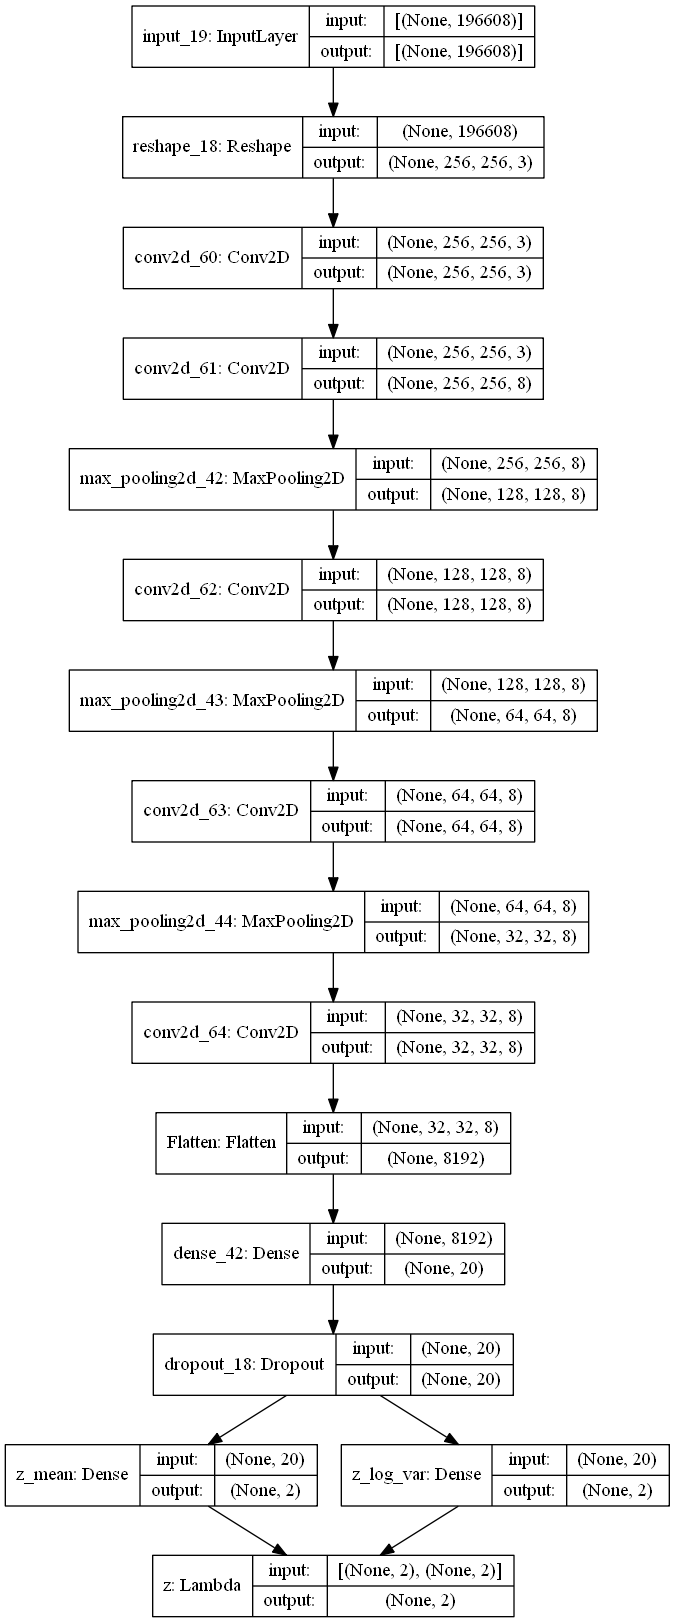

In [193]:
plot_model(encoders[0], show_shapes=True)

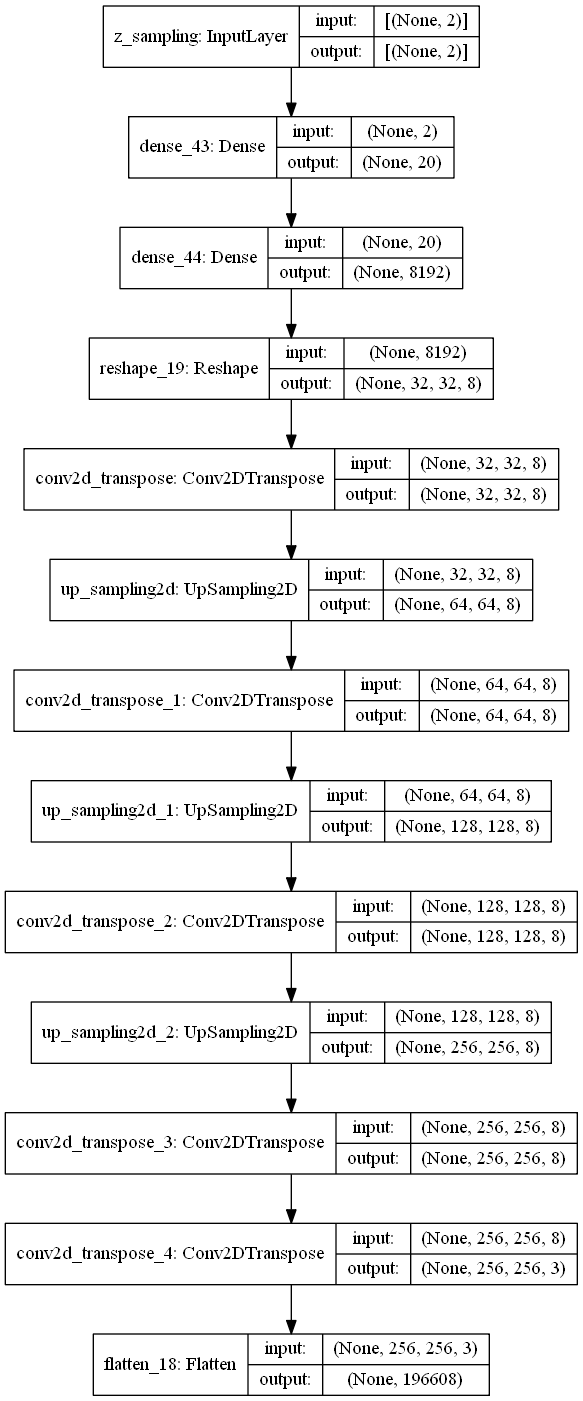

In [194]:
plot_model(decoders[0], show_shapes=True)

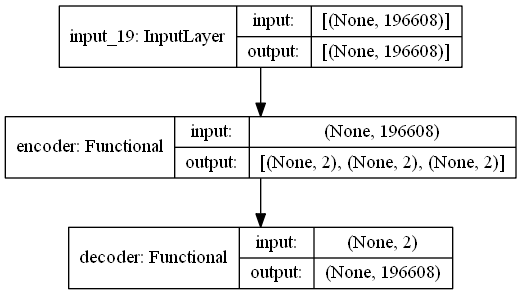

In [195]:
plot_model(vae_models[0], show_shapes=True)

In [43]:
def vae_batch_generator(X1_data, X2_data, batch_size):
    # edited batch generator function to make two dense batches for unsupervised VAE training
    samples_per_epoch = X1_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(X1_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X1_batch = X1_data[index_batch,:].todense()
        X2_batch = X2_data[index_batch,:].todense()
        counter += 1
        # max_colour is highest pixel intensity in dataset, used to scale down inputs to between 0 and 1
        # so binary cross-entropy and sigmoid activation function can be used
        yield np.array(X1_batch)/max_colour, np.array(X2_batch)/max_colour
        if (counter > number_of_batches):
            counter=0

#### Again made hyperparameter grid but would take literal weeks to train all the models so just trained one using similar architecture to best CNN as that should mean input features are being learned best.

In [44]:
validation_slice = 5000
batch_size=32
nb_epochs = 30

callbacks = []
early_stopping = EarlyStopping(patience=4, monitor="val_loss", min_delta=0.0001, verbose=1)
callbacks.append(early_stopping)
model_checkpoint = ModelCheckpoint(vae_models[0].name, monitor="val_loss", save_best_only=True, verbose=1)
callbacks.append(model_checkpoint)
reduce_lr = ReduceLROnPlateau(patience=4, verbose=1, min_lr=1e-4)
callbacks.append(reduce_lr)
vae_history = vae_models[0].fit(vae_batch_generator(x_train[:-validation_slice],x_train[:-validation_slice],batch_size=batch_size),
                          epochs=nb_epochs,
                          steps_per_epoch=int((50000-validation_slice)/batch_size),
                          validation_data=vae_batch_generator(x_train[-validation_slice:],x_train[-validation_slice:],batch_size=batch_size),
                          validation_steps=int(validation_slice/batch_size),
                          callbacks=callbacks)

Epoch 1/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 32.0000 - loss: 0.6290 - reco_loss: 0.6288 - kl_loss: 2.1232e-04

C:\Users\Matthew\Anaconda3\envs\daml2\lib\site-packages\tensorflow\python\keras\engine\training.py:2464: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.01359, saving model to VAE_VAE_C8_8_8_8_De20_Dr0.1
INFO:tensorflow:Assets written to: VAE_VAE_C8_8_8_8_De20_Dr0.1\assets
1406/1406 [==============================] - 1778s 1s/step - batch: 702.5000 - size: 32.0000 - loss: 0.6290 - reco_loss: 0.6288 - kl_loss: 2.1232e-04 - val_loss: 0.0136 - val_reco_loss: 0.0136 - val_kl_loss: 3.1382e-08 - lr: 0.0010
Epoch 2/30
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.0134 - reco_loss: 0.0134 - kl_loss: 4.3084e-08
Epoch 00002: val_loss improved from 0.01359 to 0.01352, saving model to VAE_VAE_C8_8_8_8_De20_Dr0.1
INFO:tensorflow:Assets written to: VAE_VAE_C8_8_8_8_De20_Dr0.1\assets
1406/1406 [==============================] - 1744s 1s/step - batch: 702.5000 - size: 31.9829 - loss: 0.0134 - reco_loss: 0.0134 - kl_loss: 4.3084e-08 - val_loss: 0.0135 - val_reco_loss: 0.0135 - val_kl_loss: -9.4893e-09 - lr: 0.0010
Epoch 3/30
1406/1406 [=====================

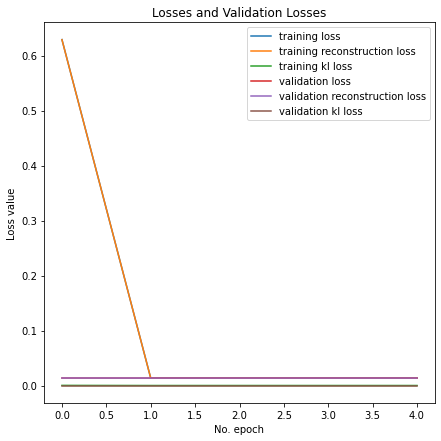

In [45]:
# Plot the two loss components and the total for both training and validation by epoch
plt.figure(figsize=(7, 7))
plt.plot(vae_history.history['loss'], label='training loss')
plt.plot(vae_history.history['reco_loss'], label='training reconstruction loss')
plt.plot(vae_history.history['kl_loss'], label='training kl loss')
plt.plot(vae_history.history['val_loss'], label='validation loss')
plt.plot(vae_history.history['val_reco_loss'], label='validation reconstruction loss')
plt.plot(vae_history.history['val_kl_loss'], label='validation kl loss')
plt.title('VAE Losses and Validation Losses')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.savefig('VAE_loss')
plt.show()

#### Loss curve is terrible. cleary hasn't learned input distribution properly. Possibly poor choice of hyperparameters, number of latent variables is too few to reconstruct complex 3-plane input images, maybe I made an error in the code. I think dividing by max_colour means a lot of images just look blank and so it doesn't even see the tracks. Could have tried relu activation and mse, instead of binarry cross-entropy and sigmoid, to avoid having to scale down pixel intensities. 

#### Regardless, that clearly this model has not bee trained successfully, I carry on to show waht I would have done.

In [83]:
# map input data to encoded latent space using encoder half of VAE
z_mean, _, _ = vae_models[0].get_layer('encoder').predict(nn_batch_generator(x_test, y_test_labels, batch_size=50),
                                                          steps=40000/50)

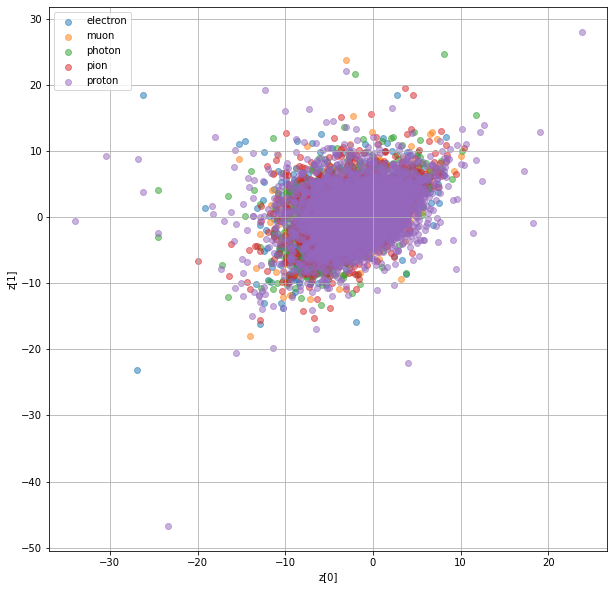

In [84]:
# Map out latentt space encodings
fig, ax = plt.subplots(figsize=(10,10))
# Loop for each class
for t in range(5):
    # Boolean mask
    mask = y_test_labels == float(t)
    # Scatter plot for current class on same axes as the rest
    single_label = z_mean[mask]
    ax.scatter(single_label[:, 0],
               single_label[:, 1],
               label=tick_names[t], alpha=0.5)
    pass

# Draw legend
ax.legend()
# Include grid lines to make chosen region of latent space for next part clear
ax.grid()
ax.set_xlabel('z[0]')
ax.set_ylabel('z[1]')
plt.show()

#### Clearly hasn't learned differences between tracks so all are stacked on top in roughly a 2D Gaussian as preferred by KL divergence.

In [149]:
type_ones = np.array([[0,0], [-8, -5], [50, 50]])

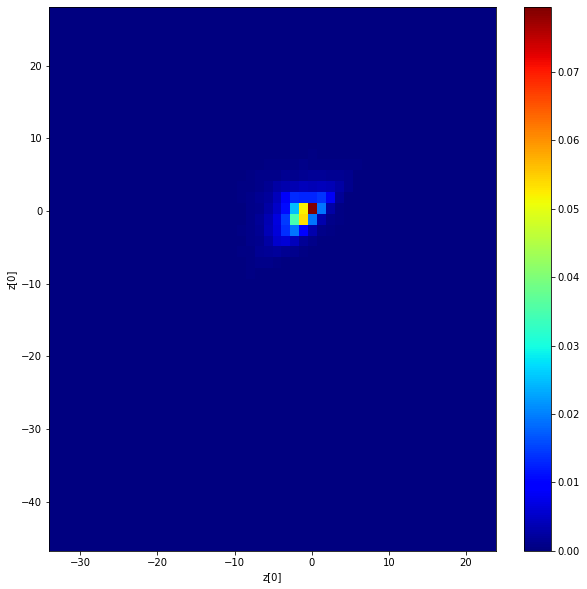

In [86]:
fig = plt.figure(figsize=(10,10))
plt.hist2d(z_mean[:, 0], z_mean[:, 1], bins=50, density=True, cmap=plt.cm.jet)
plt.colorbar()
plt.xlabel('z[0]')
plt.ylabel('z[0]')

plt.show()

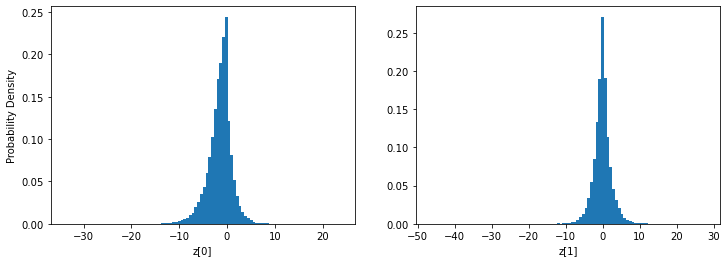

In [87]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
# Make histogram at the 
ax[0].hist(z_mean[:, 0],bins=100, density=True)
ax[1].hist(z_mean[:, 1],bins=100, density=True)

ax[0].set_xlabel('z[0]')
ax[0].set_ylabel('Probability Density')
ax[1].set_xlabel('z[1]')

plt.show()

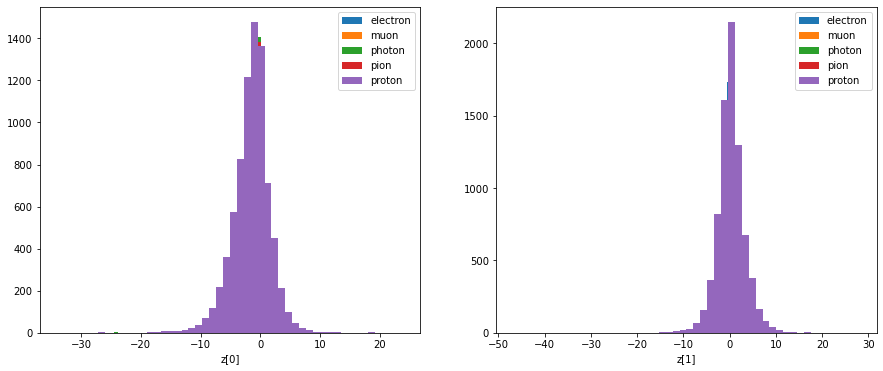

In [90]:
fig, ax = plt.subplots(1,2,figsize=(15,6))

for t in range(5):
    # Boolean mask
    mask = y_test_labels == float(t)
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    ax[0].hist(single_label[:, 0],
               bins=50, label=tick_names[t])
    ax[1].hist(single_label[:, 1],
               bins=50, label=tick_names[t])
    pass

ax[0].set_xlabel('z[0]')
ax[1].set_xlabel('z[1]')
ax[0].legend()
ax[1].legend()

plt.show()

#### Above are various Gaussians all showing the same thing, that there is no encoding distinction between classes.

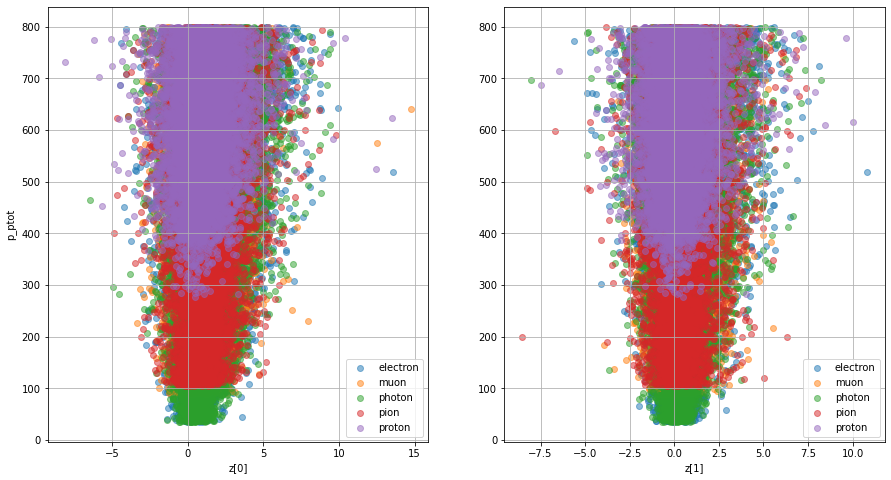

In [69]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

for t in range(5):
    # Boolean mask
    mask = y_test_labels == float(t)
    # Scatter plot for current point on same axes as the rest
    single_label = z_mean[mask]
    # plot latent encodings against momentum to look for correlations
    ax[0].scatter(single_label[:, 0],
               truth_test[y_test_labels==float(t)][:, 1],
               label=tick_names[t], alpha=0.5)
    ax[1].scatter(single_label[:, 1],
               truth_test[y_test_labels==float(t)][:, 1],
               label=tick_names[t], alpha=0.5)
    pass

# Draw legend
ax[0].legend(loc='lower right')
# Include grid lines to make chosen region of latent space clear
ax[0].grid()
ax[0].set_xlabel('z[0]')
ax[0].set_ylabel('p_ptot')
# Draw legend
ax[1].legend(loc='lower right')
# Include grid lines to make chosen region of latent space clear
ax[1].grid()
ax[1].set_xlabel('z[1]')

plt.show()

#### Look for correlations with momentum, to select encodings with high momentum or low to genrate that type of particle

In [169]:
def fantasy_plot(planes):
    #
    labels=["X-Y","Y-Z","Z-X"]
    fig = plt.figure(figsize=(30,10))

    for index, image in enumerate(planes):

        plt.subplot(1,3,index+1)
        #Show the image with imshow:
        plt.imshow(image, interpolation='none',cmap='jet')
        plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
        plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
        plt.title(labels[index])

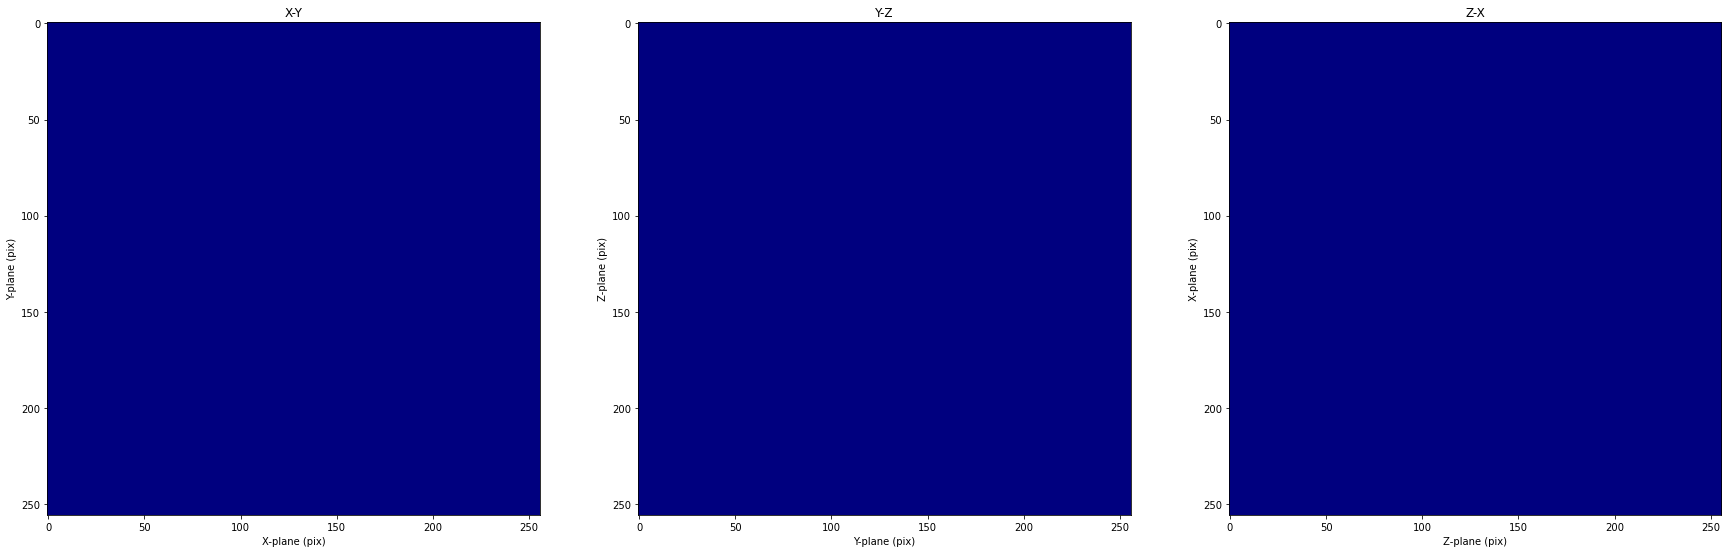

In [170]:
peak_particle = vae.get_layer('decoder').predict(np.array([type_ones[0]])).reshape((256,256,3))
peak_particle = peak_particle * max_colour
XYpeak, YZpeak, ZXpeak = peak_particle[:,:,0], peak_particle[:,:,1], peak_particle[:,:,2]
planes_peak = [XYpeak, YZpeak, ZXpeak]
fantasy_plot(planes_peak)

In [172]:
XYpeak / max_colour

array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]], dtype=float32)

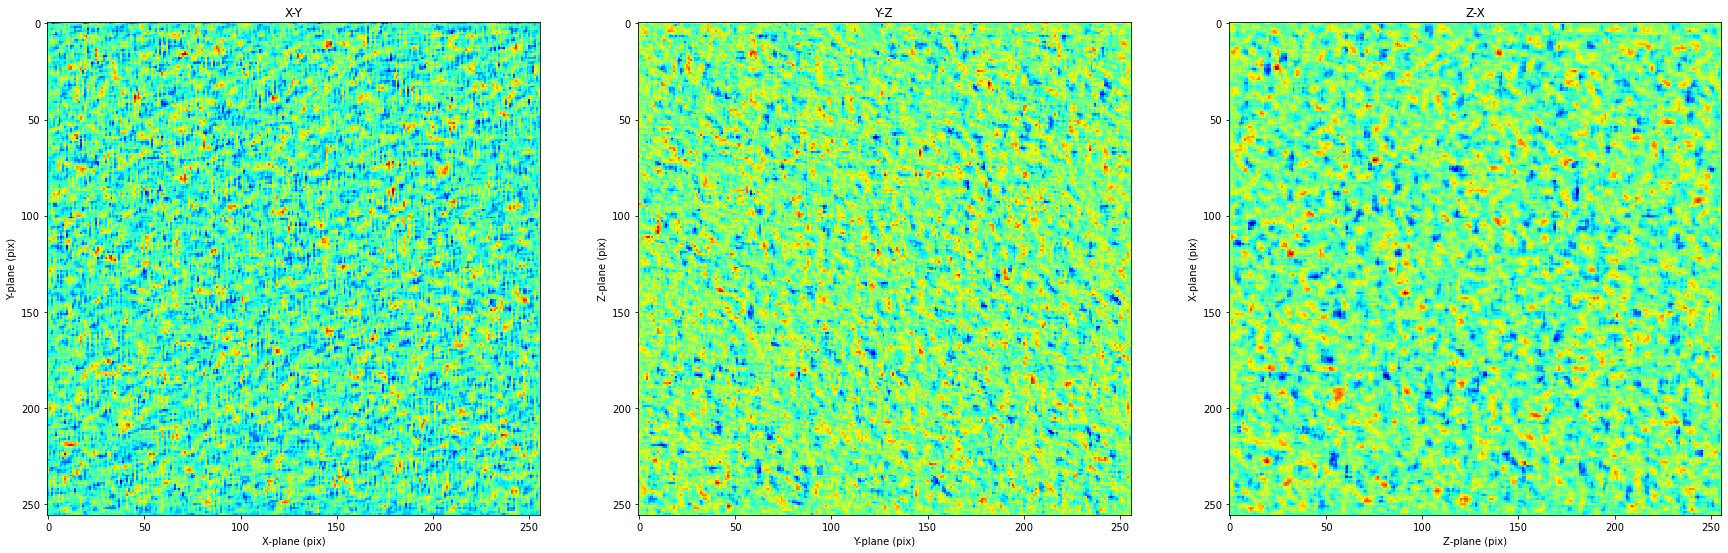

In [173]:
edge_particle = vae.get_layer('decoder').predict(np.array([type_ones[1]])).reshape((256,256,3))
edge_particle = edge_particle * max_colour
XYedge, YZedge, ZXedge = edge_particle[:,:,0], edge_particle[:,:,1], edge_particle[:,:,2]
planes_edge = [XYedge, YZedge, ZXedge]
fantasy_plot(planes_edge)

In [174]:
XYedge / max_colour

array([[0.4999109 , 0.5004577 , 0.49881813, ..., 0.4995988 , 0.4999642 ,
        0.49984458],
       [0.5008412 , 0.5011874 , 0.50126874, ..., 0.49982002, 0.5007204 ,
        0.5002801 ],
       [0.50113785, 0.50113547, 0.5002497 , ..., 0.50099367, 0.5008519 ,
        0.5001787 ],
       ...,
       [0.50015146, 0.50068176, 0.5004598 , ..., 0.5017348 , 0.501012  ,
        0.5006222 ],
       [0.50042146, 0.50140077, 0.50061446, ..., 0.5007696 , 0.4998906 ,
        0.50019246],
       [0.5004748 , 0.50066704, 0.50035197, ..., 0.5000255 , 0.49978772,
        0.5003917 ]], dtype=float32)

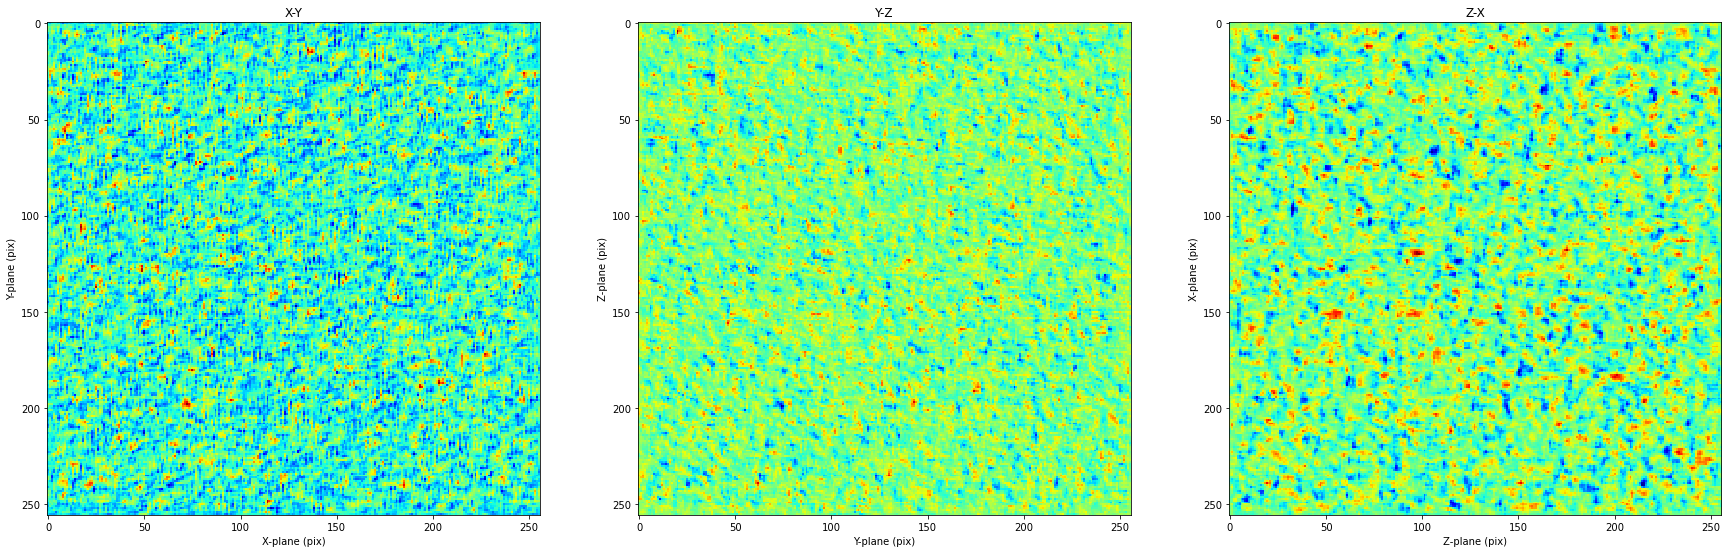

In [175]:
bad_particle = vae.get_layer('decoder').predict(np.array([type_ones[2]])).reshape((256,256,3))
bad_particle = bad_particle * max_colour
XYbad, YZbad, ZXbad = bad_particle[:,:,0], bad_particle[:,:,1], bad_particle[:,:,2]
planes_bad = [XYbad, YZbad, ZXbad]
fantasy_plot(planes_bad)

In [176]:
XYbad / max_colour

array([[0.50544894, 0.49971923, 0.5048572 , ..., 0.5077071 , 0.49997303,
        0.5048045 ],
       [0.5089951 , 0.5091504 , 0.51383543, ..., 0.50811684, 0.5049361 ,
        0.50966626],
       [0.5195479 , 0.51512235, 0.52104914, ..., 0.5073483 , 0.5100478 ,
        0.50806916],
       ...,
       [0.5008111 , 0.50450325, 0.50592595, ..., 0.5076237 , 0.49788344,
        0.5030042 ],
       [0.50425684, 0.5056445 , 0.5034818 , ..., 0.50940156, 0.49936354,
        0.5018217 ],
       [0.5021742 , 0.49721396, 0.49681374, ..., 0.4954643 , 0.49427631,
        0.49884316]], dtype=float32)

Fictional particles are terrible as expected.